<a href="https://colab.research.google.com/github/lisosoma/ML-for-demographic-inference/blob/main/ML_DI_pipeline_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install libraries

In [1]:
!pip install dadi

     |████████████████████████████████| 5.4 MB 35.5 MB/s 
     |████████████████████████████████| 424 kB 65.3 MB/s 
  Created wheel for dadi: filename=dadi-2.1.2-cp37-cp37m-linux_x86_64.whl size=413337 sha256=c37e7a2ef919ae001ec01aaa4e52898b4084bebd030c6d9cf396708db4ea9026
  Stored in directory: /root/.cache/pip/wheels/3a/e1/49/d822ad0ee9a61d16ca5b2b36b131c94b75515481d7ec36f9a1
Successfully built dadi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DE part

Generate sample data using dadi 

#### 2_DivMig_5_Sim model

In [3]:
import scipy.stats as sts
import pylab
import dadi
import numpy as np

In [386]:
def model_func(params, ns, pts):
    """
    Simple two populations model. Ancestral population of constant size splits
    into two subpopulations of constant size with asymetrical migrations.
    :param nu1: Size of subpopulation 1 after split.
    :param nu2: Size of subpopulation 2 after split.
    :param m12: Migration rate from subpopulation 2 to subpopulation 1.
    :param m21: Migration rate from subpopulation 1 to subpopulation 2.
    :param T: Time of split.
    """

    nu1, nu2, m12, m21, T = params

    xx = dadi.Numerics.default_grid(pts)
    phi = dadi.PhiManip.phi_1D(xx)

    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1=nu1, nu2=nu2, m12=m12, m21=m21)

    fs = dadi.Spectrum.from_phi(phi, ns, [xx, xx])
    return fs

In [5]:
names = np.linspace(1, 441, 441, endpoint = True, dtype = int)
a = " ".join(names.astype(str))
a += '\n'

In [337]:
with open('/content/data.txt', 'w') as f:
    f.seek(0, 2) 
    f.write(a)

#### Creating file with sample data, named current_file.txt

In [383]:
n_pop = 2
pop_labels = ["Pop 1", "Pop 2"]

par_labels = ['nu1', 'nu2', 'm12', 'm21', 'T']

lower_bound = [1e-2, 1e-2, 0, 0, 1e-15]
upper_bound = [100, 100, 10, 10, 5]

mu = 2.5e-8  # mutation rate
L = 20000000  # effective length of sequence
Nanc = 10000
theta = 4 * mu * L * Nanc  # mutation flux

ns_per_pop = 20
ns = [ns_per_pop for _ in range(n_pop)]
pts_l = 20

In [ ]:
y_cur1 = np.concatenate([[sts.uniform.rvs(loc = lower_bound[0], scale = upper_bound[0] + lower_bound[0], size = 5000).T],
                   [sts.uniform.rvs(loc = lower_bound[1], scale = upper_bound[1] + lower_bound[1], size = 5000).T],
                   [sts.uniform.rvs(loc = lower_bound[2], scale = upper_bound[2] + lower_bound[2], size = 5000).T],
                   [sts.uniform.rvs(loc = lower_bound[3], scale = upper_bound[3] + lower_bound[3], size = 5000).T],
                   [sts.uniform.rvs(loc = 0.001, scale = 0.101, size = 5000).T]]).T

In [ ]:
np.savetxt(r'labels1.txt', pd.DataFrame(y_cur1))

In [ ]:
k = 1000
y1 = np.array([[0.1, 5, 2.5, 0.05]]* k)
y1 = np.concatenate([[np.linspace(lower_bound[0], upper_bound[0], k, endpoint = True)], y1.T]).T
y2 = np.array([[5, 2.5, 0.05]]*k)
y2 = np.concatenate([[np.ones(k)], [np.linspace(lower_bound[1], upper_bound[1], k, endpoint = True)], y2.T]).T
y3 = np.concatenate([np.array([[1, 0.1]]* k).T, [np.linspace(lower_bound[2], upper_bound[2], k, endpoint = True)], np.array([[2.5, 0.05]]* k).T]).T
y4 = np.array([[1, 0.1, 5]]*k)
y4 = np.concatenate([y4.T, [np.linspace(lower_bound[3], upper_bound[3], k, endpoint = True)], np.array([[0.05]] * k).T]).T
y5 = np.array([[1, 0.1, 5, 2.5]]* k)
y5 = np.concatenate([y5.T, [np.linspace(lower_bound[4], upper_bound[4], k, endpoint = True)]]).T
y_cur2 = np.concatenate([y1, y2, y3, y4, y5])

In [ ]:
np.savetxt(r'labels2.txt', pd.DataFrame(y_cur2))

In [ ]:
for i, u in tqdm(enumerate(y_cur1)):
    popt = u
    func_ex = dadi.Numerics.make_extrap_log_func(model_func)
    model = func_ex(popt, ns, pts_l)
    data = model * theta

    data.to_file(f'/content/fs_data.txt')
    with open('/content/fs_data.txt', 'r') as f:
        for i in range(1):
            f.readline()
        x = f.readline()
        with open('/content/data1.txt', 'r+') as f:
            f.seek(0, 2) 
            f.write(x)

    #pylab.figure(i)
    #dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
    #pylab.savefig(f'/content/image/fs{i}.jpeg', dpi=300)

5000it [02:59, 27.88it/s]


In [ ]:
!cp labels2.txt /content/drive/MyDrive/ML_DI

### ML part

#### Import tools

In [8]:
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import train_test_split as tr
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, cross_val_score, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages

from scipy.optimize import root
from scipy.stats import randint, uniform
from math import sqrt, exp, sin

import os
from tqdm import tqdm
import pickle
import random

#### Create data

- Save data to `DataFrame`

In [ ]:
X = pd.read_table('/content/current_file.txt',sep='\s+', engine='python')

In [ ]:
y = np.linspace(0, 10, 10000, endpoint = True)

- Create train and test samples

In [ ]:
X_train, X_test, y_train, y_test = tr(X, y, train_size = 0.7, random_state=500, shuffle = True)

- For multioutput regression

In [ ]:
X_cur1 = pd.read_table('/content/drive/MyDrive/ML_DI/data1.txt',sep='\s+', engine='python').to_numpy()
y_cur1 = pd.read_table('/content/drive/MyDrive/ML_DI/labels1.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()

In [ ]:
X_cur2 = pd.read_table('/content/drive/MyDrive/ML_DI/data2.txt',sep='\s+', engine='python').to_numpy()
y_cur2 = pd.read_table('/content/drive/MyDrive/ML_DI/labels2.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()

In [ ]:
X_train1, X_test1, y_train1, y_test1 = tr(X_cur1, y_cur1, train_size = 0.5, random_state=500, shuffle = True)
X_train2, X_test2, y_train2, y_test2 = tr(X_cur2, y_cur2, train_size = 0.5, random_state=500, shuffle = True)

In [ ]:
np.savetxt(r'X_train1.txt', pd.DataFrame(X_train1))
np.savetxt(r'X_test1.txt', pd.DataFrame(X_test1))
np.savetxt(r'y_train1.txt', pd.DataFrame(y_train1))
np.savetxt(r'y_test1.txt', pd.DataFrame(y_test1))
np.savetxt(r'X_train2.txt', pd.DataFrame(X_train2))
np.savetxt(r'X_test2.txt', pd.DataFrame(X_test2))
np.savetxt(r'y_train2.txt', pd.DataFrame(y_train2))
np.savetxt(r'y_test2.txt', pd.DataFrame(y_test2))

We load previously created datasets, divided into test and training samples

In [ ]:
names = np.linspace(1, 441, 441, endpoint = True, dtype = int)
a = " ".join(names.astype(str))
a += '\n'

In [9]:
y_train1 = pd.read_table('/content/drive/MyDrive/ML_DI/y_train1.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
y_train2 = pd.read_table('/content/drive/MyDrive/ML_DI/y_train2.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
y_test1 = pd.read_table('/content/drive/MyDrive/ML_DI/y_test1.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
y_test2 = pd.read_table('/content/drive/MyDrive/ML_DI/y_test2.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
X_train1 = pd.read_table('/content/drive/MyDrive/ML_DI/X_train1.txt',sep='\s+', engine='python', names = names).to_numpy()
X_train2 = pd.read_table('/content/drive/MyDrive/ML_DI/X_train2.txt',sep='\s+', engine='python', names = names).to_numpy()
X_test1 = pd.read_table('/content/drive/MyDrive/ML_DI/X_test1.txt',sep='\s+', engine='python', names = names).to_numpy()
X_test2 = pd.read_table('/content/drive/MyDrive/ML_DI/X_test2.txt',sep='\s+', engine='python', names = names).to_numpy()

### Random Forest

#### Train model

In [ ]:
rfr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=50)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=0)

#### Test model

In [ ]:
y_pred = rfr.predict(X_test)
print(f'For Random Forest with max_depth = {rfr.max_depth} and n_estimators = {rfr.n_estimators}:')
print(f'R2 score is equal to {r2_score(y_test, y_pred)}')
print(f'MSE score is equal to {mean_squared_error(y_test, y_pred)}')
print(f'Variance of errors is equal to {mean_squared_error(y_test, y_pred) / 3000}')
#mean_pinball_loss(y_test, y_pred)

For Random Forest with max_depth = 8 and n_estimators = 50:
R2 score is equal to 0.9999990977370584
MSE score is equal to 7.468155350707657e-06
Variance of errors is equal to 2.4893851169025523e-09


#### Choose best parameters

For choosing best parameters we used RandomizedSearchCV

In [ ]:
distributions = dict(max_depth = randint(5, 10),
                     n_estimators = randint(low=10, high=100))

grid_search = RandomizedSearchCV(rfr, param_distributions = distributions, scoring='r2')

print('\n Start Grid Search')
grid_search.fit(X, y)


 Start Grid Search


RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=8, n_estimators=50,
                                                   random_state=0),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdabbb7c50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbda129a350>},
                   scoring='r2')

In [ ]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([52.68689861, 46.16657119, 28.03199906, 38.50385628, 42.08063216,
        7.70518565, 34.65662947, 62.45977182, 44.060425  , 47.7232728 ]), 'std_fit_time': array([0.44404409, 0.53290464, 0.23685854, 0.46930044, 0.21322383,
       0.05660717, 0.63547442, 0.46048697, 0.61156525, 0.31785638]), 'mean_score_time': array([0.03470478, 0.02649779, 0.01870799, 0.02349873, 0.02383065,
       0.01054263, 0.02358041, 0.03441739, 0.02522588, 0.02823648]), 'std_score_time': array([0.00588109, 0.00388215, 0.00068244, 0.00288311, 0.00061708,
       0.00060239, 0.00089407, 0.00060257, 0.00111534, 0.0031924 ]), 'param_max_depth': masked_array(data=[8, 5, 5, 5, 5, 5, 8, 7, 6, 6],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[76, 88, 54, 74, 83, 15, 51, 98, 76, 84],
             mask=[False, False, False, False, Fal

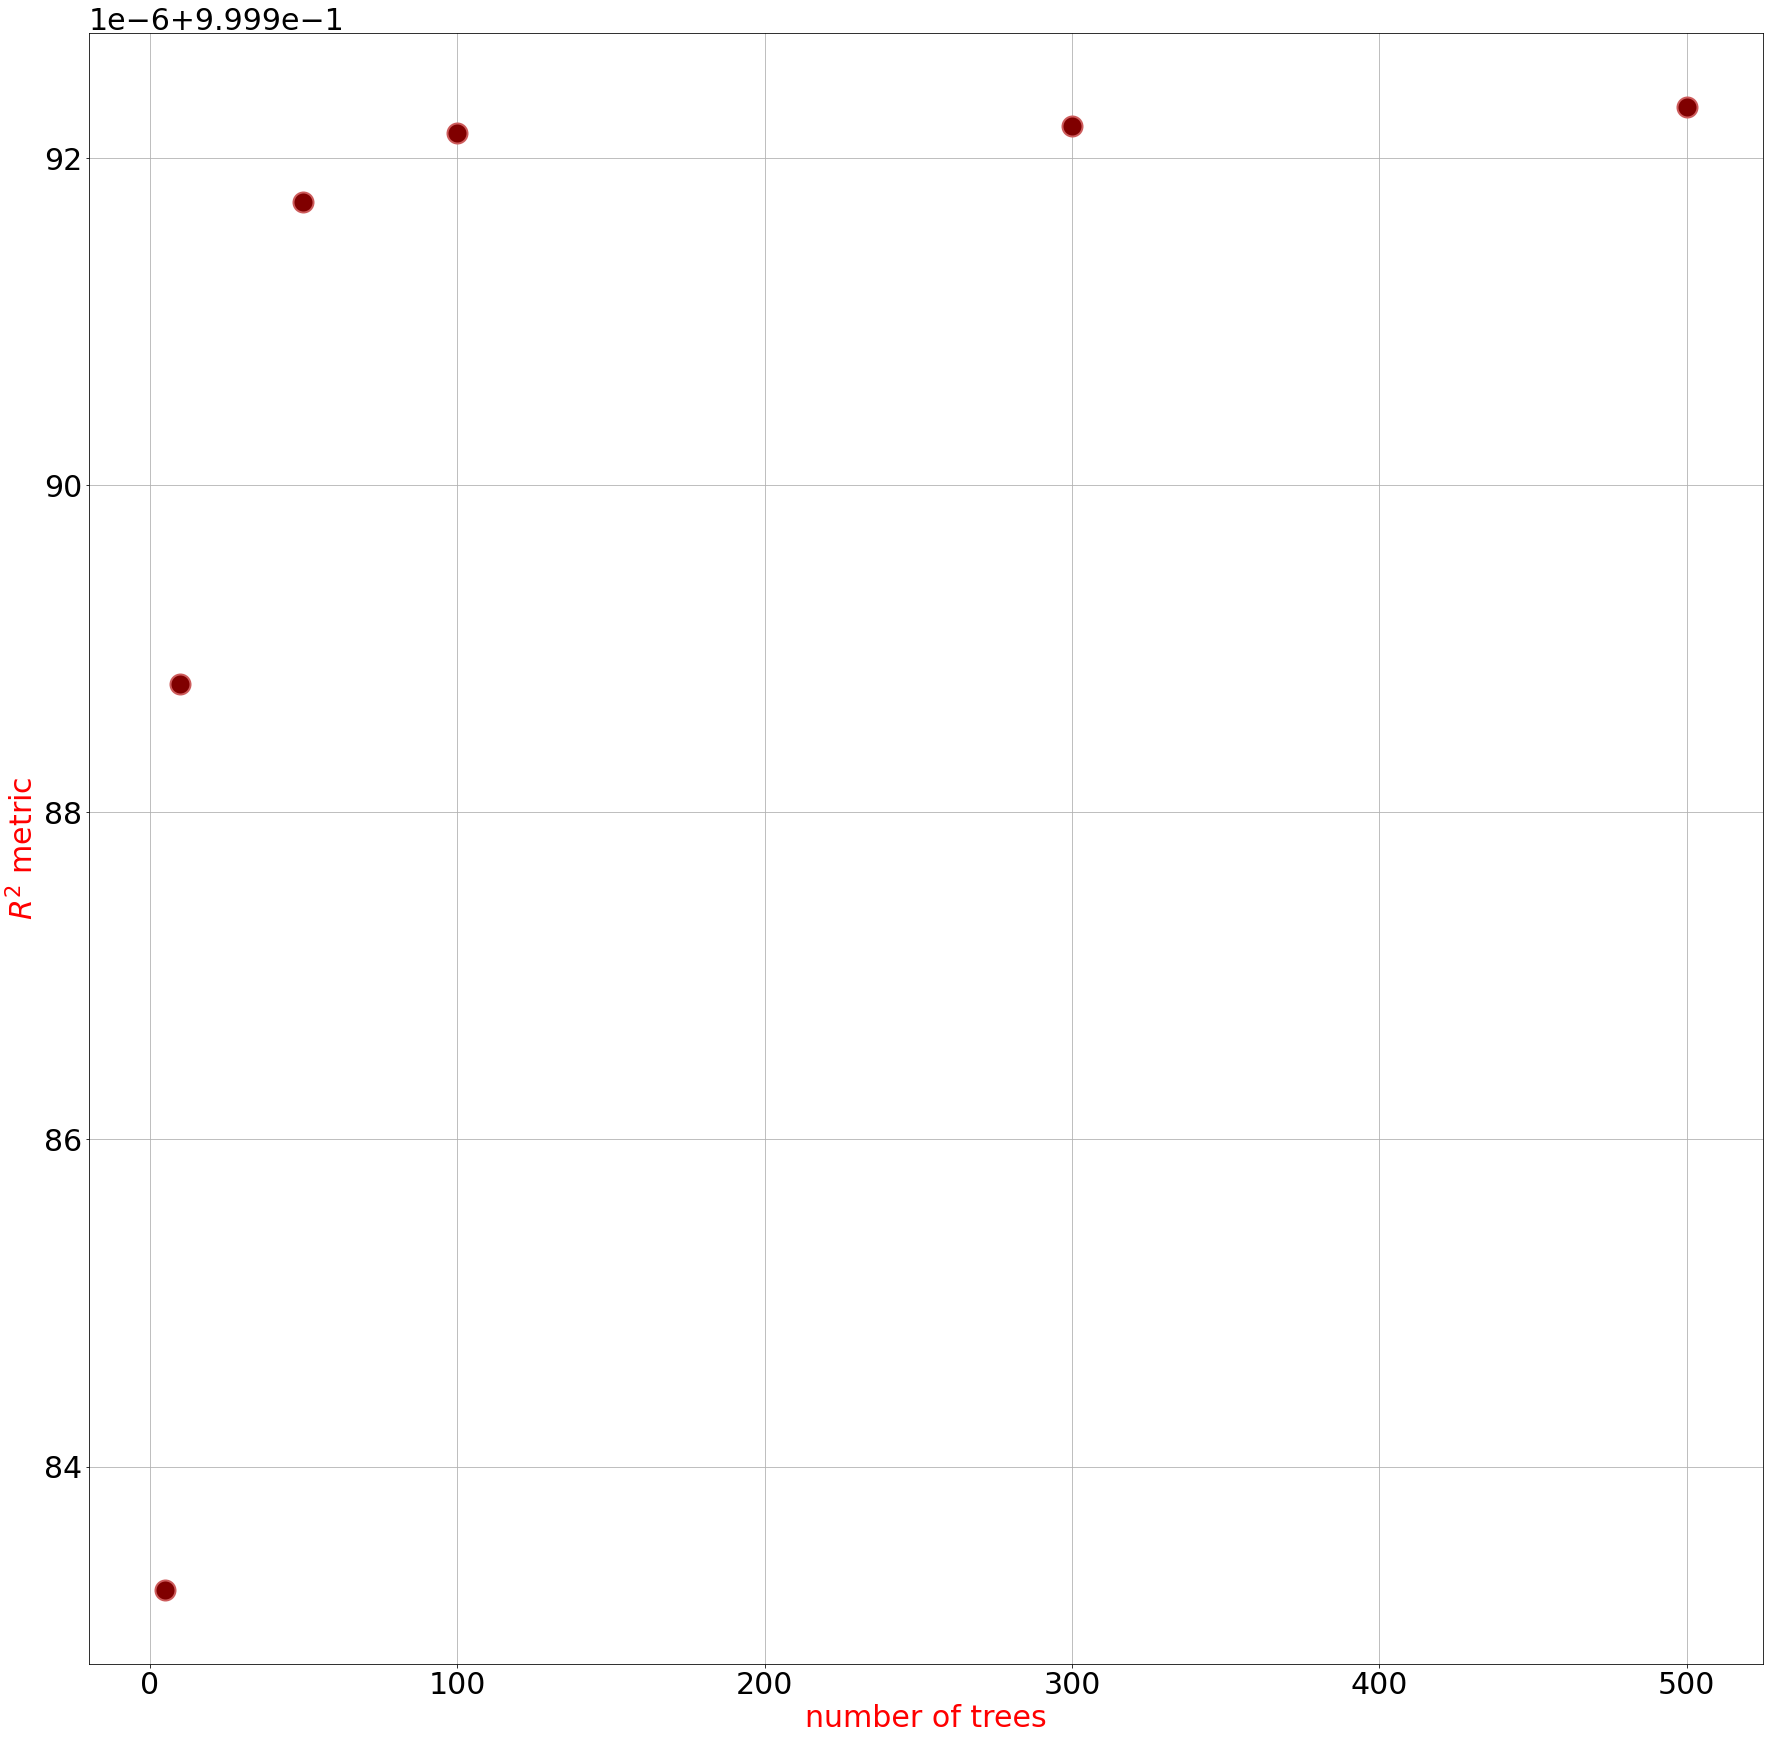

In [ ]:
def graphic(x, y, s):
    fig = plt.figure(figsize=(30, 30))
    
    plt.xlabel('number of trees', fontsize=30, color='red')
    plt.ylabel(fr'{s}', fontsize=30, color='red')
    plt.rcParams.update({'font.size': 30})
    plt.plot(x, y, color='indianred', linewidth = 0, marker = 'o', markersize = 20, markerfacecolor = 'maroon',
            markeredgecolor = 'indianred', markeredgewidth = 2)
    plt.grid(True)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Calibri'
    with PdfPages(f'{s}.pdf') as pdf:
        pdf.savefig()

graphic(K, r2, s = '$R^2$ metric')

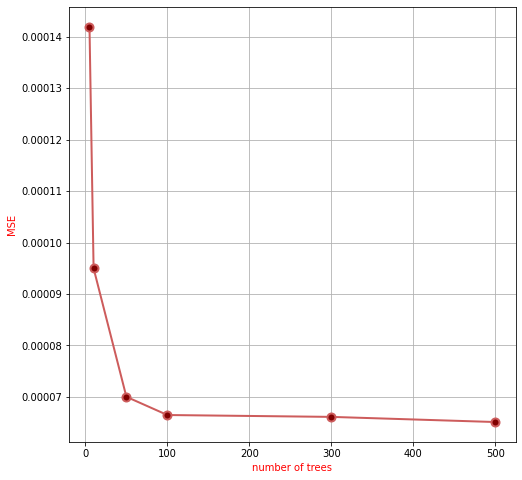

In [ ]:
graphic(K, mse, s = 'MSE')

In [ ]:
rfr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [ ]:
y_pred = rfr.predict(X_test)
print(f'For Random Forest with max_depth = {rfr.max_depth} and n_estimators = {rfr.n_estimators}:')
print(f'R2 score is equal to {r2_score(y_test, y_pred)}')
print(f'MSE score is equal to {mean_squared_error(y_test, y_pred)}')
print(f'Variance of errors is equal to {mean_squared_error(y_test, y_pred) / 3000}')

For Random Forest with max_depth = 8 and n_estimators = 76:
R2 score is equal to 0.9999991786601288
MSE score is equal to 6.7983438878673756e-06
Variance of errors is equal to 2.266114629289125e-09


In [ ]:
ny = np.linspace(1, 300, 300, endpoint = True, dtype=int)

In [ ]:
def graphic_y(x, yt, yp, n):
    fig = plt.figure(figsize=(30, 15))
    
    plt.xlabel('point', fontsize=30, color='green')
    plt.ylabel(fr'parameter', fontsize=30, color='green')
    plt.rcParams.update({'font.size': 30})
    plt.plot(x, yt, color='red', linewidth = 1, marker = 'o', markersize = 15, markerfacecolor = 'maroon',
            markeredgecolor = 'indianred', markeredgewidth = 2, label = 'true', alpha = 0.3)
    plt.plot(x, yp, color='red', linewidth = 1, marker = 'o', markersize = 15, markerfacecolor = 'plum',
            markeredgecolor = 'indigo', markeredgewidth = 2, label = 'predict')
    plt.grid(True)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Calibri'
    with PdfPages(f'сравнение{n}.pdf') as pdf:
        pdf.savefig()
    plt.legend()

#graphic_y(ny[:50], y_test[:50], y_pred[:50], 50)

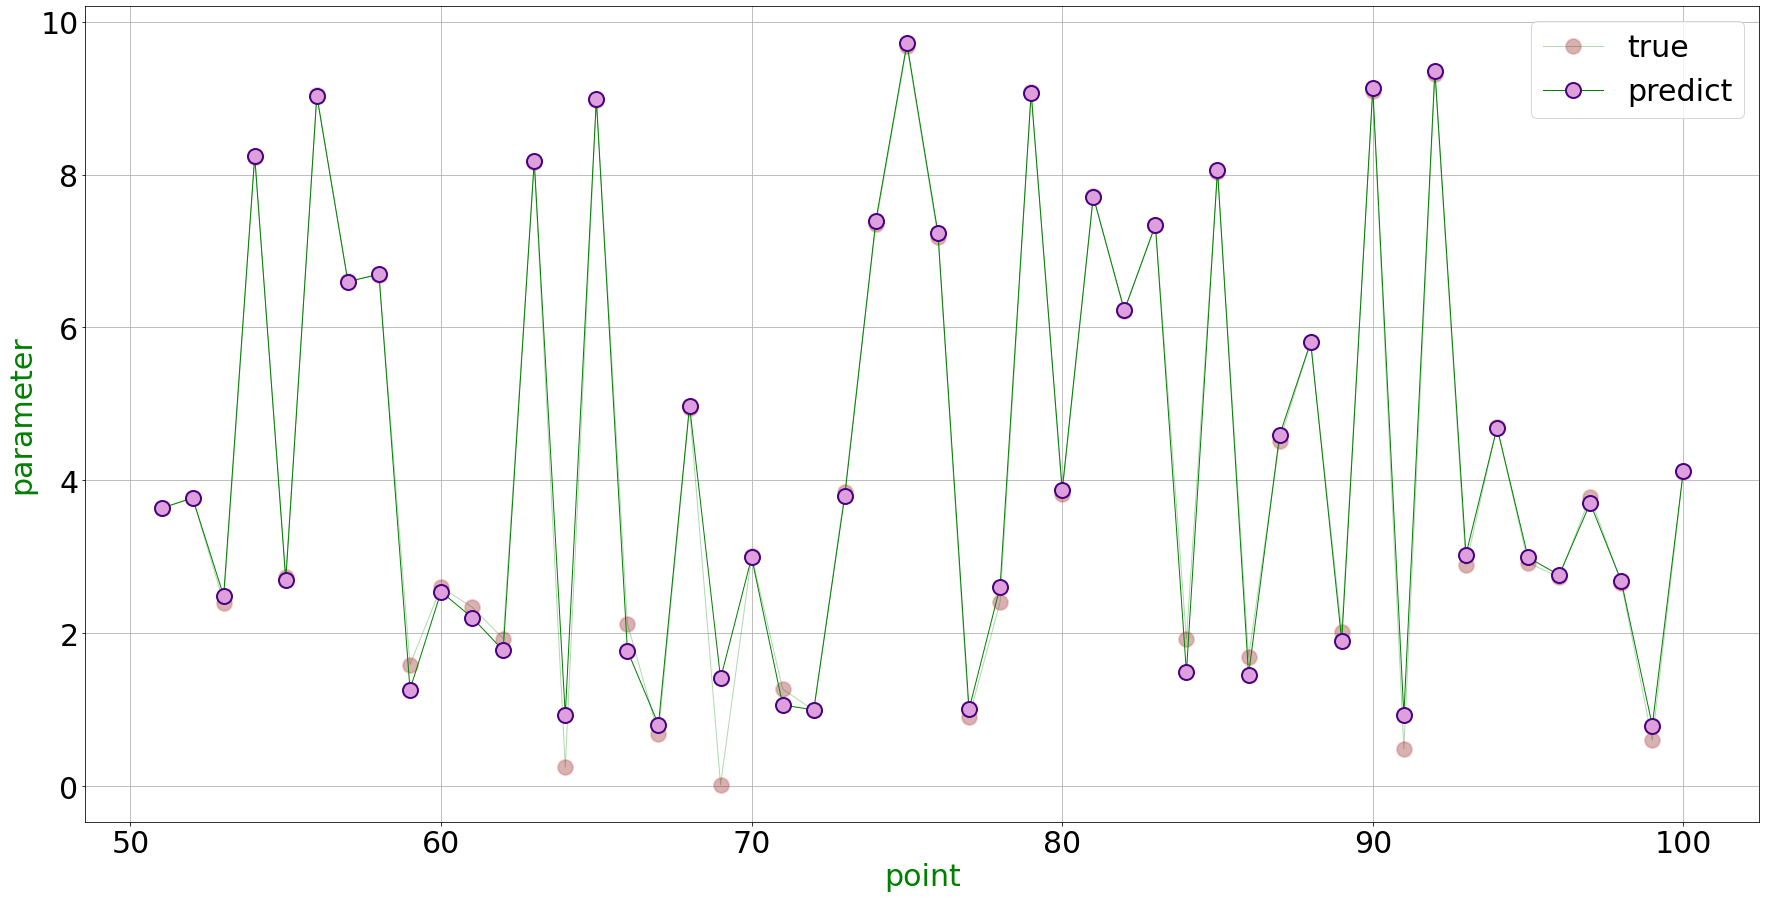

In [ ]:
graphic_y(ny[50:100], y_test[50:100], y_pred[50:100], 100)

- Predict four demographic history parameters: independent parameter prediction

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper = MultiOutputRegressor(model)
#wrapper.fit(X_cur2, y_cur2)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(wrapper, X_cur2, y_cur2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores = np.absolute(n_scores)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 0.012 (0.011)


In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
#wrapper1 = MultiOutputRegressor(model)
#wrapper1.fit(X_train1, y_train1)

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper2 = MultiOutputRegressor(model)
wrapper2.fit(X_train2, y_train2)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=8,
                                                     n_estimators=76,
                                                     random_state=0))

 - Prediction

In [ ]:
y_pred1 = wrapper1.predict(X_test1)

In [ ]:
y_pred2 = wrapper2.predict(X_test2)

- Let's check metrics for any predicted pdrdmeters

In [ ]:
parameters = ['Size of subpopulation 1 after split',
              'Size of subpopulation 2 after split',
              'Migration rate from subpopulation 2 to subpopulation 1',
              'Migration rate from subpopulation 1 to subpopulation 2', 
              'Time of split']

In [ ]:
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
    print(f'For {parameters[i]}\n')
    print(f'R2 score is equal to {r2_score(y_test1.T[i], y_pred1.T[i])}')
    print(f'MSE score is equal to {mean_squared_error(y_test1.T[i], y_pred1.T[i])}\n')

Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.8175157795047018
MSE score is equal to 150.35083624869395

For Size of subpopulation 2 after split

R2 score is equal to 0.80465488323843
MSE score is equal to 158.71238271513187

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9393491890233879
MSE score is equal to 0.5181080741112235

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9323921410977929
MSE score is equal to 0.5796252133554906

For Time of split

R2 score is equal to 0.9883595702862131
MSE score is equal to 9.695708059429739e-06



In [ ]:
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
    print(f'For {parameters[i]}\n')
    print(f'R2 score is equal to {r2_score(y_test2.T[i], y_pred2.T[i])}')
    print(f'MSE score is equal to {mean_squared_error(y_test2.T[i], y_pred2.T[i])}\n')

Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.999930365729071
MSE score is equal to 0.041002134813948155

For Size of subpopulation 2 after split

R2 score is equal to 0.9947055546618725
MSE score is equal to 3.0351503922192715

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9889953979547029
MSE score is equal to 0.018410626472790563

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9996131776972046
MSE score is equal to 0.0010197846737629974

For Time of split

R2 score is equal to 0.9936168007319683
MSE score is equal to 0.008951257386572428



Saving models

In [ ]:
filename = 'MultiOutputRegressor1.sav'
pickle.dump(wrapper1, open(filename, 'wb'))
filename = 'MultiOutputRegressor2.sav'
pickle.dump(wrapper2, open(filename, 'wb'))

- Chained multioutput regression

In [ ]:
wrapper2 = RegressorChain(model)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(wrapper2, X_cur2, y_cur2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores = np.absolute(n_scores)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper3 = RegressorChain(model)
wrapper3.fit(X_train1, y_train1)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=8,
                                                    n_estimators=76,
                                                    random_state=0))

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper4 = RegressorChain(model)
wrapper4.fit(X_train2, y_train2)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=8,
                                                    n_estimators=76,
                                                    random_state=0))

In [ ]:
y_pred3 = wrapper3.predict(X_test1)
y_pred4 = wrapper4.predict(X_test2)

In [ ]:
filename = 'RegressorChain1.sav'
pickle.dump(wrapper3, open(filename, 'wb'))
filename = 'RegressorChain2.sav'
pickle.dump(wrapper4, open(filename, 'wb'))

In [ ]:
!cp RegressorChain2.sav /content/drive/MyDrive/ML_DI

- Let's look at the predicted parameters separately and calculate the metrics

In [ ]:
print('Chained multioutput regression')
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
  print(f'For {parameters[i]}\n')
  print(f'R2 score is equal to {r2_score(y_test1.T[i], y_pred3.T[i])}')
  print(f'MSE score is equal to {mean_squared_error(y_test1.T[i], y_pred3.T[i])}\n')

Chained multioutput regression
Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.8175157795047018
MSE score is equal to 150.35083624869395

For Size of subpopulation 2 after split

R2 score is equal to 0.8047905234000596
MSE score is equal to 158.60217891991553

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9401330651275113
MSE score is equal to 0.5114118316025161

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9352565215373589
MSE score is equal to 0.5550679037412889

For Time of split

R2 score is equal to 0.9884800942322846
MSE score is equal to 9.595319583745224e-06



In [ ]:
print('Chained multioutput regression')
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
  print(f'For {parameters[i]}\n')
  print(f'R2 score is equal to {r2_score(y_test2.T[i], y_pred4.T[i])}')
  print(f'MSE score is equal to {mean_squared_error(y_test2.T[i], y_pred4.T[i])}\n')

Chained multioutput regression
Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.999930365729071
MSE score is equal to 0.041002134813948155

For Size of subpopulation 2 after split

R2 score is equal to 0.9953230285641524
MSE score is equal to 2.681170695197222

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9885147481957837
MSE score is equal to 0.01921475034199314

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9996607319752575
MSE score is equal to 0.0008944167113167355

For Time of split

R2 score is equal to 0.9931832126285584
MSE score is equal to 0.009559284576451485



In [ ]:
s_max = 100000
i_max = 0
for i in range(len(y_pred1)):
  s = sum((y_pred1[i] - y_test1[i]) ** 2)
  if s <= s_max:
    s_max = s
    i_max = i
i_max, s_max

(1975, 0.26531672797116046)

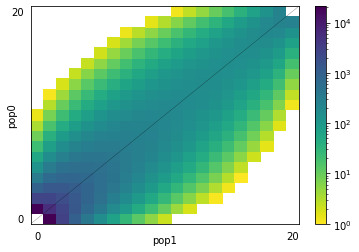

In [ ]:
popt = y_test1[1975]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/true1.jpeg', dpi=300)

In [ ]:
print(y_test1[1975])

[6.28960298e+01 1.53831048e+01 7.05036631e+00 4.59788985e-01
 3.09343946e-02]


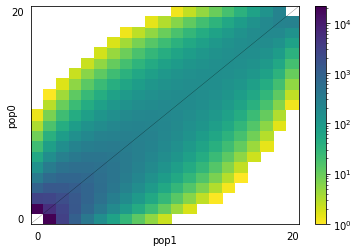

In [ ]:
popt = y_pred1[1975]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred1.jpeg', dpi=300)

In [ ]:
print(y_pred1[1975])

[6.28530617e+01 1.56489892e+01 7.47511894e+00 3.48610842e-01
 3.16936124e-02]


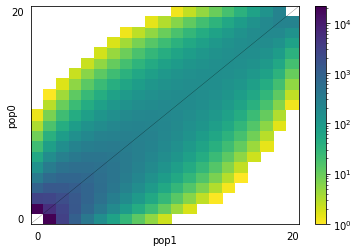

In [ ]:
popt = y_pred3[1975]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred1.jpeg', dpi=300)

In [ ]:
print(y_pred3[1975])

[6.28530617e+01 1.63629541e+01 7.45202589e+00 3.75310971e-01
 3.15604909e-02]


In [ ]:
s_max = 0
i_max = 0
for i in range(len(y_pred3)):
  s = sum((y_pred3[i] - y_test2[i]) ** 2)
  if s > s_max:
    s_max = s
    i_max = i
i_max, s_max

(2345, 17.622025440628992)

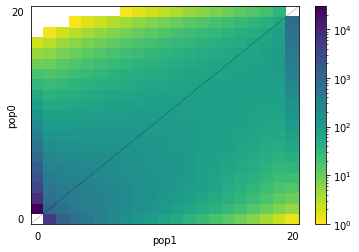

In [ ]:
popt = y_test2[2345]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/true1.jpeg', dpi=300)

In [ ]:
print(y_test2[2345])

[6.1165045e+01 1.0000000e-01 5.0000000e+00 2.5000000e+00 5.0000000e-02]


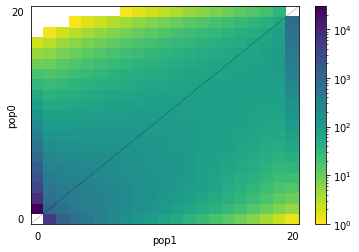

In [ ]:
popt = y_pred2[2345]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred1.jpeg', dpi=300)

In [ ]:
print(y_pred2[2345])

[6.12329027e+01 1.00000000e-01 5.00000000e+00 2.49997009e+00
 5.00000013e-02]


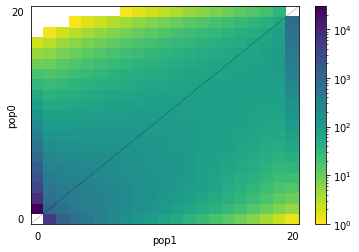

In [ ]:
popt = y_pred4[2345]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred1.jpeg', dpi=300)

In [ ]:
print(y_pred4[2345])

[6.12329027e+01 1.00000000e-01 5.00000000e+00 2.49997009e+00
 5.00000013e-02]


### Download models

In [10]:
filename1 = '/content/drive/MyDrive/ML_DI/MultiOutputRegressor1.sav'
MultiOutputRegressor1 = pickle.load(open(filename1, 'rb'))
filename2 = '/content/drive/MyDrive/ML_DI/MultiOutputRegressor2.sav'
MultiOutputRegressor2 = pickle.load(open(filename2, 'rb'))
filename3 = '/content/drive/MyDrive/ML_DI/RegressorChain1.sav'
RegressorChain1 = pickle.load(open(filename3, 'rb'))
filename4 = '/content/drive/MyDrive/ML_DI/RegressorChain2.sav'
RegressorChain2 = pickle.load(open(filename4, 'rb'))

In [11]:
y_pred1 = MultiOutputRegressor1.predict(X_test1)
y_pred2 = MultiOutputRegressor2.predict(X_test2)
y_pred3 = RegressorChain1.predict(X_test1)
y_pred4 = RegressorChain2.predict(X_test2)

### Metrics

In [ ]:
!pip install git+https://bitbucket.org/simongravel/moments.git

In [13]:
import moments

In [14]:
N = 1000 # number of random points
M = 5 # size of test sample
K = 50

In [41]:
LL_min = []

In [380]:
ll = []
NN = []

In [133]:
LL_min

[2.305158698661444,
 0.5697180539959845,
 1.4811977203953575,
 13.654876628186685,
 0.22877746598692283,
 4.1662444483142735,
 0.6127186604612689,
 18.33700050076004,
 1.2846549475816573,
 30.497371057817872,
 0.2893061692639094,
 1.5241335408563828,
 0.6405812156426691,
 15.780277758518423,
 0.9688846220803953,
 1.1753473394164757,
 1.5036808409035984,
 5.618128644319768,
 7.643275682730746,
 2.7566720494851324,
 0.7991833922853857,
 0.21648502090079091,
 1.1459642429872474,
 0.7311549685500722,
 0.7355465285418177,
 0.2713887177892502,
 0.07147491730756883,
 4.215049057347642,
 0.06905371624634427]

In [135]:
np.mean(np.array(LL_min))

4.11356229680466

In [378]:
len(NN)

36

In [296]:
NN_2 = np.array(NN)
NN_mean2 = np.mean(NN_2)
NN_mean2

854.4722222222222

In [400]:
NN_3 = np.array(NN)
NN_mean3 = np.mean(NN_3)
NN_mean3

410.4

In [401]:
y_test1_for_metrics = y_test2[5:15]

In [ ]:
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
eps = 5
for y in tqdm(y_test1_for_metrics):
    idx = np.where(y_test1_for_metrics == y)
    data = func_ex(y, ns, pts_l) * theta
    model = func_ex(y_pred3[idx[0][0]], ns, pts_l)
    ll_model = moments.Inference.ll_multinom(model, data)
    ll_model_random = 0
    i = 0
    while abs(ll_model - ll_model_random) > eps:
        i += 1
        y_random = np.array([sts.uniform.rvs(loc = lower_bound[0], scale = upper_bound[0] + lower_bound[0]),
                            sts.uniform.rvs(loc = lower_bound[1], scale = upper_bound[1] + lower_bound[1]),
                            sts.uniform.rvs(loc = lower_bound[2], scale = upper_bound[2] + lower_bound[2]),
                            sts.uniform.rvs(loc = lower_bound[3], scale = upper_bound[3] + lower_bound[3]),
                            sts.uniform.rvs(loc = 0.001, scale = 0.101)]).T
        model_random = func_ex(y_random, ns, pts_l)
        ll_model_random = moments.Inference.ll_multinom(model_random, data)
        nn = i
    NN.append(nn)
    ll.append(ll_model_random)

  0%|          | 0/10 [00:00<?, ?it/s]WARNING:Inference:Model is masked in some entries where data is not.


848.6385155743586 85503.51428734396
354.5833579216836 85503.51428734396
0.9964112937963134 85503.51428734396
9.756322115307668 85503.51428734396
13.851774066728275 85503.51428734396
26.142688077294753 85503.51428734396


565.6725842939335 85503.51428734396
250.46110161334883 85503.51428734396
166.75553840859715 85503.51428734396
78.97769880893148 85503.51428734396


846.13530115029 85503.51428734396
25.02294624963611 85503.51428734396
76.03829252332112 85503.51428734396
25.02294624963611 85503.51428734396
542.7347222072677 85503.51428734396


54.22923311592395 85503.51428734396
404.60585065828667 85503.51428734396
946.961898538993 85503.51428734396
54.22923311592395

 85503.51428734396
49.69629377654546 85503.51428734396
284.1173118424437 85503.51428734396
386.07150224908287 85503.51428734396


516.6010858393904 85503.51428734396
153.40835493037258 85503.51428734396
25.02294624963611 85503.51428734396
294.7310394037512 85503.51428734396
10.876063942966313 85503.51428734396


94.81573491630496 85503.51428734396
949.9376086627549 85503.51428734396
5.091863245216921 85503.51428734396
357.08096229969254 85503.51428734396


164.76368210446006 85503.51428734396
872.5817610110204 85503.51428734396
98.92354719922018 85503.51428734396


848.6385155743586 85503.51428734396
270.43282998713715 85503.51428734396
129.05763662912614 85503.51428734396
170.55372031511996 85503.51428734396


23.297893665155723 85503.51428734396
16.791180352338635 85503.51428734396
255.82153049021673 85503.51428734396
26.142688077294753 85503.51428734396
26.142688077294753 85503.51428734396


94.81573491630496 85503.51428734396
94.81573491630496 85503.51428734396
800.9694638563283 85503.51428734396
46.00194973563154 85503.51428734396


799.2940072634674 85503.51428734396
410.0855140187833 85503.51428734396
94.81573491630496 85503.51428734396
0.9964112937963134 85503.51428734396


350.13361891104347 85503.51428734396
91.12139087539103 85503.51428734396
164.05760566147953 85503.51428734396
156.6611438709555 85503.51428734396


1041.8812607342597 85503.51428734396
235.13221291047822 85503.51428734396
54.22923311592395 85503.51428734396
869.0531312609845 85503.51428734396


337.82181897462476 85503.51428734396
302.982490103231 85503.51428734396
477.82849714881183 85503.51428734396


396.9007523230912 85503.51428734396
69.31287847988878 85503.51428734396
431.980687258952 85503.51428734396


948.7029046422513 85503.51428734396
318.9001902592777 85503.51428734396
26.142688077294753 85503.51428734396
268.82038603029355 85503.51428734396


175.7902489604727 85503.51428734396
865.9848087620741 85503.51428734396
118.27631623905435 85503.51428734396
75.98293264456467 85503.51428734396


10.876063942966313 85503.51428734396
302.982490103231 85503.51428734396
270.35255704497536 85503.51428734396
126.11577499906923 85503.51428734396


803.5695060074222 85503.51428734396
378.094948302497 85503.51428734396


1024.8872029091456 85503.51428734396
759.1741619971642 85503.51428734396
8.759910821511355 85503.51428734396


174.0115440977362 85503.51428734396
229.19196833367843 85503.51428734396
1170.99574764622 85503.51428734396
0.9964112937963134 85503.51428734396


767.3769609212885 85503.51428734396
94.81573491630496 85503.51428734396
374.8669505702547 85503.51428734396
164.76368210446006 85503.51428734396


422.08226138897686 85503.51428734396
32.05780448666708 85503.51428734396
158.16301320781557 85503.51428734396
0.9964112937963134 85503.51428734396
227.402591613111 85503.51428734396


900.9942468526407 85503.51428734396
25.02294624963611 85503.51428734396
26.142688077294753 85503.51428734396
235.13221291047822 85503.51428734396


271.42385046667687 85503.51428734396
979.5799526237533 85503.51428734396


1176.793133967189 85503.51428734396
1155.666002028086 85503.51428734396
102.28808054129381 85503.51428734396


156.6611438709555 85503.51428734396
979.5799526237533 85503.51428734396
126.11577499906923 85503.51428734396


946.961898538993 85503.51428734396
448.4123621509119 85503.51428734396
94.81573491630496 85503.51428734396


302.982490103231 85503.51428734396
404.60585065828667 85503.51428734396
179.97207261521277 85503.51428734396
46.00194973563154 85503.51428734396
153.56220213977736 85503.51428734396
166.033926845165 85503.51428734396


267.74413759511424 85503.51428734396
403.47259285860343 85503.51428734396
302.982490103231 85503.51428734396
137.82814610981416 85503.51428734396
54.22923311592395 85503.51428734396
54.22923311592395 85503.51428734396
73.00667550890779 85503.51428734396
47.5038190724916 85503.51428734396


94.81573491630496 85503.51428734396
968.4132629578504 85503.51428734396
36.18963591553888 85503.51428734396
302.982490103231 85503.51428734396
33.55967382352714 85503.51428734396
354.5833579216836 85503.51428734396


127.45081318774409 85503.51428734396
302.982490103231 85503.51428734396
156.6611438709555 85503.51428734396
375.80743387922877 85503.51428734396
302.982490103231 85503.51428734396
139.4967580483476 85503.51428734396


127.11882476852116 85503.51428734396
418.3972331029106 85503.51428734396
365.59732057738194 85503.51428734396
25.02294624963611 85503.51428734396
519.9221934040164 85503.51428734396
565.6725842939335 85503.51428734396


946.961898538993 85503.51428734396
94.81573491630496 85503.51428734396
467.1038505182949 85503.51428734396
664.8337327563218 85503.51428734396
174.0115440977362 85503.51428734396
32.05780448666708 85503.51428734396
36.18963591553888 85503.51428734396


25.02294624963611 85503.51428734396
0.9964112937963134 85503.51428734396
26.142688077294753 85503.51428734396
54.173873237167484 85503.51428734396
9.756322115307668 85503.51428734396
391.68925388948225 85503.51428734396
404.60585065828667 85503.51428734396
25.02294624963611 85503.51428734396


302.982490103231 85503.51428734396
32.05780448666708 85503.51428734396
0.9964112937963134 85503.51428734396
46.00194973563154 85503.51428734396
997.4407757684374 85503.51428734396
388.8294400104297 85503.51428734396
26.142688077294753 85503.51428734396


431.50904391288094 85503.51428734396
647.4289943971418 85503.51428734396
94.81573491630496 85503.51428734396
339.92740028415136 85503.51428734396
35.193224621742566 85503.51428734396
94.81573491630496 85503.51428734396
46.00194973563154 85503.51428734396


1007.1993894420391 85503.51428734396
8.759910821511355 85503.51428734396
958.1285882048957 85503.51428734396
124.99603317141059 85503.51428734396
32.05780448666708 85503.51428734396
48.977659859393505 85503.51428734396


117.19141830897648 85503.51428734396
75.98293264456467 85503.51428734396
9.756322115307668 85503.51428734396
94.81573491630496 85503.51428734396
159.10518595304825 85503.51428734396
46.00194973563154 85503.51428734396
302.982490103231 85503.51428734396


283.0107617294427 85503.51428734396
373.9047997661227 85503.51428734396
174.0115440977362 85503.51428734396
296.0731581456588 85503.51428734396
565.2216467879117 85503.51428734396
94.81573491630496 85503.51428734396


309.67645014285637 85503.51428734396
302.982490103231 85503.51428734396
154.2739828403147 85503.51428734396
729.0739622827456 85503.51428734396
1061.6499567595147 85503.51428734396


94.81573491630496 85503.51428734396
391.68925388948225 85503.51428734396
564.3436300009494 85503.51428734396
568.9936918585595 85503.51428734396
100.78621120443374 85503.51428734396
174.0115440977362 85503.51428734396


8.759910821511355 85503.51428734396
560.4263600134927 85503.51428734396
221.7866283638013 85503.51428734396
288.0790046931156 85503.51428734396
386.07150224908287 85503.51428734396
26.142688077294753 85503.51428734396
54.173873237167484 85503.51428734396


94.81573491630496 85503.51428734396
9.756322115307668 85503.51428734396
202.9205906305872 85503.51428734396
164.76368210446006 85503.51428734396
26.142688077294753 85503.51428734396
939.5239789192649 85503.51428734396
137.82814610981416 85503.51428734396


302.982490103231 85503.51428734396
160.10823572250018 85503.51428734396
9.756322115307668 85503.51428734396
1049.656394386342 85503.51428734396
636.422144856358 85503.51428734396


174.0115440977362 85503.51428734396
101.61120948841808 85503.51428734396
153.56220213977736 85503.51428734396
1016.2527884010053 85503.51428734396
302.982490103231 85503.51428734396
100.78621120443374 85503.51428734396


284.1173118424437 85503.51428734396
551.0155351949851 85503.51428734396
291.27115388248853 85503.51428734396
75.98293264456467 85503.51428734396
876.8193099369863 85503.51428734396


848.6385155743586 85503.51428734396
720.9720791074888 85503.51428734396
43.06254345002118 85503.51428734396
262.18137928765736 85503.51428734396
0.9964112937963134 85503.51428734396
137.99488871148753 85503.51428734396


581.9871838254873 85503.51428734396
26.142688077294753 85503.51428734396
617.6189614695928 85503.51428734396
26.142688077294753 85503.51428734396
26.142688077294753 85503.51428734396
10.876063942966313 85503.51428734396
184.14177102786255 85503.51428734396


532.7188744064225 85503.51428734396
129.23497788997614 85503.51428734396
78.97769880893148 85503.51428734396
302.982490103231 85503.51428734396
175.7902489604727 85503.51428734396
302.982490103231 85503.51428734396
60.56021762369122 85503.51428734396


393.019588546804 85503.51428734396
46.00194973563154 85503.51428734396
410.0855140187833 85503.51428734396
9.756322115307668 85503.51428734396
912.1609365185435 85503.51428734396
516.6010858393904 85503.51428734396


54.173873237167484 85503.51428734396
9.756322115307668 85503.51428734396
404.4322586876016 85503.51428734396
54.22923311592395 85503.51428734396
315.1639251322281 85503.51428734396
8.759910821511355 85503.51428734396


26.142688077294753 85503.51428734396
0.9964112937963134 85503.51428734396
183.0185738367219 85503.51428734396
0.9964112937963134 85503.51428734396
302.982490103231 85503.51428734396
29.118398201056714 85503.51428734396
127.6176443359293 85503.51428734396
325.3581734959025 85503.51428734396


50.479529196253566 85503.51428734396
200.67633112224058 85503.51428734396
0.9964112937963134 85503.51428734396
566.7996569392237 85503.51428734396
712.6101283914145 85503.51428734396
128.23856659617982 85503.51428734396


261.7416284497722 85503.51428734396
772.1929992879362 85503.51428734396
336.15486904141915 85503.51428734396
37.25401786444107 85503.51428734396
26.142688077294753 85503.51428734396
559.9194185871098 85503.51428734396


94.81573491630496 85503.51428734396
179.97207261521277 85503.51428734396
285.6191811793038 85503.51428734396
221.7866283638013 85503.51428734396
908.6313528838002 85503.51428734396
182.58724516060002 85503.51428734396


1063.4743038408328 85503.51428734396
76.03829252332112 85503.51428734396
180.53869660048707 85503.51428734396
374.8669505702547 85503.51428734396
266.74772630131787 85503.51428734396
32.05780448666708 85503.51428734396


1214.3728289153346 85503.51428734396
321.06347162562 85503.51428734396
302.982490103231 85503.51428734396
958.1285882048957 85503.51428734396
97.84680491882338 85503.51428734396


900.9942468526407 85503.51428734396
602.0753713858546 85503.51428734396
302.982490103231 85503.51428734396
823.6387242531843 85503.51428734396
516.6010858393904 85503.51428734396


174.0115440977362 85503.51428734396
554.332827224296 85503.51428734396
680.531253153866 85503.51428734396
863.009098638312 85503.51428734396


173.01513280393988 85503.51428734396
1046.803017666019 85503.51428734396
54.173873237167484 85503.51428734396
1104.887283745144 85503.51428734396
584.8178116726501 85503.51428734396


1389.2479254863051 85503.51428734396
54.22923311592395 85503.51428734396
26.142688077294753 85503.51428734396
540.32649700882 85503.51428734396
308.00107520940395 85503.51428734396
54.22923311592395 85503.51428734396
81.37286573729209 85503.51428734396
48.977659859393505 85503.51428734396


936.5482687955028 85503.51428734396
946.6165010981289 85503.51428734396
1150.1810593304303 85503.51428734396
69.31287847988878 85503.51428734396
94.81573491630496 85503.51428734396


233.66574207621957 85503.51428734396
36.18963591553888 85503.51428734396
113.83504061658392 85503.51428734396
302.982490103231 85503.51428734396
401.4565485638396 85503.51428734396
400.99038743869903 85503.51428734396


946.6165010981289 85503.51428734396
161.1046470162965 85503.51428734396
302.982490103231 85503.51428734396
208.22901965588395 85503.51428734396
94.81573491630496 85503.51428734396
94.81573491630496 85503.51428734396


565.2216467879117 85503.51428734396
13.851774066728275 85503.51428734396
57.16863940153431 85503.51428734396
105.74670788486888 85503.51428734396
182.58572353258583 85503.51428734396
530.8802491946385 85503.51428734396


863.009098638312 85503.51428734396
26.142688077294753 85503.51428734396
26.142688077294753 85503.51428734396
136.99847741769122 85503.51428734396
912.0082095083391 85503.51428734396


184.14177102786255 85503.51428734396
164.91259457043532 85503.51428734396
387.81801431022154 85503.51428734396
155.06407147663742 85503.51428734396
46.00194973563154 85503.51428734396
251.19234090769353 85503.51428734396


365.59732057738194 85503.51428734396
128.23856659617982 85503.51428734396
179.97207261521277 85503.51428734396
584.8178116726501 85503.51428734396


204.82763324411908 85503.51428734396
54.173873237167484 85503.51428734396
137.99488871148753 85503.51428734396
78.97769880893148 85503.51428734396
9.756322115307668 85503.51428734396
76.03829252332112 85503.51428734396
302.982490103231 85503.51428734396
24.026534955839796 85503.51428734396


302.982490103231 85503.51428734396
1171.2768190823967 85503.51428734396
776.2104900972034 85503.51428734396
94.81573491630496 85503.51428734396
60.56021762369122 85503.51428734396


164.76368210446006 85503.51428734396
25.02294624963611 85503.51428734396
680.531253153866 85503.51428734396
378.56024614808257 85503.51428734396
213.0179942608034 85503.51428734396


2.1161531214549583 85503.51428734396
732.0475178704529 85503.51428734396
1214.0597155817118 85503.51428734396
76.03829252332112 85503.51428734396


748.2349883414718 85503.51428734396
113.83504061658392 85503.51428734396
354.5833579216836 85503.51428734396
182.0221625429256 85503.51428734396
25.02294624963611 85503.51428734396
302.982490103231 85503.51428734396


704.9047423806055 85503.51428734396
48.977659859393505 85503.51428734396
941.7348097386306 85503.51428734396
138.5003467545513 85503.51428734396
26.142688077294753 85503.51428734396
378.094948302497 85503.51428734396


225.06621122506775 85503.51428734396
958.1285882048957 85503.51428734396
25.02294624963611 85503.51428734396
908.6313528838002 85503.51428734396


818.757032893686 85503.51428734396
32.05780448666708 85503.51428734396
674.7677614811276 85503.51428734396
26.142688077294753 85503.51428734396
201.45797123844423 85503.51428734396
94.81573491630496 85503.51428734396
94.81573491630496 85503.51428734396


19.926600487414124 85503.51428734396
24.026534955839796 85503.51428734396
365.59732057738194 85503.51428734396
0.9964112937963134 85503.51428734396
0.9964112937963134 85503.51428734396
382.0294192634567 85503.51428734396


333.61513622383006 85503.51428734396
2.1161531214549583 85503.51428734396
270.7959687113502 85503.51428734396
137.99488871148753 85503.51428734396
198.43072680617456 85503.51428734396
633.0975719264768 85503.51428734396
100.78621120443374 85503.51428734396


182.58724516060002 85503.51428734396
10.876063942966313 85503.51428734396
360.6681342646203 85503.51428734396
43.06254345002118 85503.51428734396
29.082094362905117 85503.51428734396
270.7959687113502 85503.51428734396


580.1462870322187 85503.51428734396
150.76730271083656 85503.51428734396
626.5932912398367 85503.51428734396
25.02294624963611 85503.51428734396
32.05780448666708 85503.51428734396
609.3860902595674 85503.51428734396
26.142688077294753 85503.51428734396


569.8418356972155 85503.51428734396
113.83504061658392 85503.51428734396
25.02294624963611 85503.51428734396
175.7902489604727 85503.51428734396
9.756322115307668 85503.51428734396
9.756322115307668 85503.51428734396
740.0191762367715 85503.51428734396


156.6611438709555 85503.51428734396
94.81573491630496 85503.51428734396
36.18963591553888 85503.51428734396
531.473801673253 85503.51428734396
302.982490103231 85503.51428734396
979.2824735303365 85503.51428734396


302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
365.59732057738194 85503.51428734396
57.16863940153431 85503.51428734396
880.7435927400799 85503.51428734396
167.03033813896133 85503.51428734396


0.9964112937963134 85503.51428734396
639.743252420984 85503.51428734396
378.3050382572377 85503.51428734396
579.1617894403471 85503.51428734396
26.142688077294753 85503.51428734396
150.76730271083656 85503.51428734396
250.46110161334883 85503.51428734396


94.81573491630496 85503.51428734396
46.00194973563154 85503.51428734396
166.033926845165 85503.51428734396
373.9047997661227 85503.51428734396
26.142688077294753 85503.51428734396
643.9125038242661 85503.51428734396


555.2876180631058 85503.51428734396
751.5480311626037 85503.51428734396
302.982490103231 85503.51428734396
131.89208881021452 85503.51428734396
48.977659859393505 85503.51428734396
24.026534955839796 85503.51428734396


941.7348097386306 85503.51428734396
94.81573491630496 85503.51428734396
37.25401786444107 85503.51428734396
674.7677614811276 85503.51428734396
26.142688077294753 85503.51428734396
713.626696751682 85503.51428734396


888.5024578371326 85503.51428734396
270.7959687113502 85503.51428734396
94.81573491630496 85503.51428734396
584.8178116726501 85503.51428734396
233.72567444474836 85503.51428734396
138.5003467545513 85503.51428734396
2.1161531214549583 85503.51428734396


46.00194973563154 85503.51428734396
137.99488871148753 85503.51428734396
144.88669114107503 85503.51428734396
302.982490103231 85503.51428734396
10.876063942966313 85503.51428734396
94.81573491630496 85503.51428734396


404.60585065828667 85503.51428734396
378.56024614808257 85503.51428734396
285.6191811793038 85503.51428734396
302.982490103231 85503.51428734396
8.759910821511355 85503.51428734396
54.173873237167484 85503.51428734396


52.11307999446899 85503.51428734396
26.142688077294753 85503.51428734396
84.06872336303998 85503.51428734396
131.89208881021452 85503.51428734396
8.759910821511355 85503.51428734396
755.4633826344565 85503.51428734396


354.5833579216836 85503.51428734396
684.8122619879202 85503.51428734396
229.46064516096834 85503.51428734396
863.8260424606221 85503.51428734396
343.18724858049023 85503.51428734396
10.876063942966313 85503.51428734396
302.982490103231 85503.51428734396


915.4820440831695 85503.51428734396
8.759910821511355 85503.51428734396
251.19234090769353 85503.51428734396
57.16863940153431 85503.51428734396
569.8418356972155 85503.51428734396


1070.1809784944317 85503.51428734396
94.81573491630496 85503.51428734396
8.759910821511355 85503.51428734396
94.81573491630496 85503.51428734396
207.44188985508134 85503.51428734396
137.99488871148753 85503.51428734396
935.6025384424305 85503.51428734396


620.5583677552032 85503.51428734396
9.756322115307668 85503.51428734396
218.64268079159964 85503.51428734396
13.851774066728275 85503.51428734396
602.0753713858546 85503.51428734396
302.982490103231 85503.51428734396
32.05780448666708 85503.51428734396


113.83504061658392 85503.51428734396
26.142688077294753 85503.51428734396
9.756322115307668 85503.51428734396
357.08096229969254 85503.51428734396
548.7527289212071 85503.51428734396
946.961898538993 85503.51428734396


373.9047997661227 85503.51428734396
893.4438259975365 85503.51428734396
180.53869660048707 85503.51428734396
379.5372858803371 85503.51428734396
8.759910821511355 85503.51428734396


25.02294624963611 85503.51428734396
302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
164.76368210446006 85503.51428734396
9.756322115307668 85503.51428734396
452.969828179699 85503.51428734396


354.5833579216836 85503.51428734396
937.7139725182697 85503.51428734396
37.25401786444107 85503.51428734396
204.82763324411908 85503.51428734396
984.8156511506945 85503.51428734396


118.16547965654985 85503.51428734396
0.9964112937963134 85503.51428734396
503.4329339000572 85503.51428734396
357.08096229969254 85503.51428734396
46.00194973563154 85503.51428734396
670.4131233177493 85503.51428734396


218.64268079159964 85503.51428734396
94.81573491630496 85503.51428734396
9.756322115307668 85503.51428734396
178.4702032783527 85503.51428734396
241.91719277569936 85503.51428734396
8.759910821511355 85503.51428734396
302.982490103231 85503.51428734396


457.2142977351715 85503.51428734396
100.78621120443374 85503.51428734396
9.756322115307668 85503.51428734396
271.42385046667687 85503.51428734396
674.7677614811276 85503.51428734396
302.982490103231 85503.51428734396


412.04699922166657 85503.51428734396
26.142688077294753 85503.51428734396
270.7959687113502 85503.51428734396
302.982490103231 85503.51428734396
59.563806329894916 85503.51428734396
580.9710369943484 85503.51428734396


372.46195631798764 85503.51428734396
9.756322115307668 85503.51428734396
303.34562882744405 85503.51428734396
945.130620209977 85503.51428734396
354.5833579216836 85503.51428734396
118.16547965654985 85503.51428734396


57.16863940153431 85503.51428734396
388.73908877723306 85503.51428734396
26.142688077294753 85503.51428734396
302.982490103231 85503.51428734396
54.173873237167484 85503.51428734396
25.02294624963611 85503.51428734396


97.98902203515843 85503.51428734396
218.64268079159964 85503.51428734396
183.58365645439633 85503.51428734396
94.81573491630496 85503.51428734396
26.142688077294753 85503.51428734396
94.81573491630496 85503.51428734396
33.55967382352714 85503.51428734396
266.74772630131787 85503.51428734396


29.118398201056714 85503.51428734396
150.76730271083656 85503.51428734396
43.640362250964806 85503.51428734396
54.22923311592395 85503.51428734396
302.982490103231 85503.51428734396
111.69665675954265 85503.51428734396
8.759910821511355 85503.51428734396


302.982490103231 85503.51428734396
143.10729317441192 85503.51428734396
122.26216205701301 85503.51428734396
302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
863.009098638312 85503.51428734396


8.759910821511355 85503.51428734396
888.2167371971741 85503.51428734396
348.0928026163733 85503.51428734396
54.22923311592395 85503.51428734396
13.851774066728275 85503.51428734396


384.15943340665893 85503.51428734396
823.9841216940483 85503.51428734396
26.142688077294753 85503.51428734396
770.540123066082 85503.51428734396
701.9653360949951 85503.51428734396


279.46186546048386 85503.51428734396
969.2000952394793 85503.51428734396
76.03829252332112 85503.51428734396
75.98293264456467 85503.51428734396
83.26607038767538 85503.51428734396
13.851774066728275 85503.51428734396


26.142688077294753 85503.51428734396
26.142688077294753 85503.51428734396
712.6101283914145 85503.51428734396
123.07817874557271 85503.51428734396
143.10729317441192 85503.51428734396
94.81573491630496 85503.51428734396
9.756322115307668 85503.51428734396


488.2454070137935 85503.51428734396
851.4970115315454 85503.51428734396
160.20382950248572 85503.51428734396
54.22923311592395 85503.51428734396
926.496006738868 85503.51428734396


43.640362250964806 85503.51428734396
314.82194124220666 85503.51428734396
302.982490103231 85503.51428734396
8.759910821511355 85503.51428734396
494.0070437728892 85503.51428734396
153.40835493037258 85503.51428734396


435.5687375701784 85503.51428734396
10.876063942966313 85503.51428734396
102.28808054129381 85503.51428734396
0.9964112937963134 85503.51428734396
153.40835493037258 85503.51428734396
232.03754012652936 85503.51428734396
302.982490103231 85503.51428734396


54.173873237167484 85503.51428734396
609.3860902595674 85503.51428734396
121.94607658641945 85503.51428734396
302.982490103231 85503.51428734396
360.9418741954221 85503.51428734396
267.7006442026349 85503.51428734396


54.22923311592395 85503.51428734396
46.00194973563154 85503.51428734396
431.50904391288094 85503.51428734396
165.76009339825637 85503.51428734396
71.50480617204772 85503.51428734396
182.58724516060002 85503.51428734396


26.142688077294753 85503.51428734396
43.06254345002118 85503.51428734396
32.05780448666708 85503.51428734396
25.02294624963611 85503.51428734396
275.40257319435125 85503.51428734396
164.76368210446006 85503.51428734396


509.9139507171238 85503.51428734396
378.094948302497 85503.51428734396
32.05780448666708 85503.51428734396
302.982490103231 85503.51428734396
123.07817874557271 85503.51428734396
404.60585065828667 85503.51428734396


266.74772630131787 85503.51428734396
46.00194973563154 85503.51428734396
94.81573491630496 85503.51428734396
57.16863940153431 85503.51428734396
946.6165010981289 85503.51428734396
799.5101385710428 85503.51428734396


54.22923311592395 85503.51428734396
701.6709547357219 85503.51428734396
57.16863940153431 85503.51428734396
117.19141830897648 85503.51428734396
321.06347162562 85503.51428734396
94.81573491630496 85503.51428734396


113.83504061658392 85503.51428734396
608.4645728290355 85503.51428734396
163.0611943676832 85503.51428734396
78.97769880893148 85503.51428734396
14.417613917351025 85503.51428734396


527.8093202505546 85503.51428734396
26.142688077294753 85503.51428734396
467.1038505182949 85503.51428734396
134.33302568235013 85503.51428734396
8.759910821511355 85503.51428734396
0.9964112937963134 85503.51428734396


549.0633271386171 85503.51428734396
958.1285882048957 85503.51428734396
908.6313528838002 85503.51428734396
946.6165010981289 85503.51428734396


946.6165010981289 85503.51428734396
302.982490103231 85503.51428734396
53.1094912882653 85503.51428734396
94.81573491630496 85503.51428734396
946.6165010981289 85503.51428734396
54.22923311592395 85503.51428734396


164.76368210446006 85503.51428734396
100.78621120443374 85503.51428734396
741.1389180644302 85503.51428734396
146.80163721532585 85503.51428734396
13.851774066728275 85503.51428734396
156.6611438709555 85503.51428734396


543.5042790939849 85503.51428734396
1211.0840054579503 85503.51428734396
979.5799526237533 85503.51428734396
302.982490103231 85503.51428734396
25.02294624963611 85503.51428734396


94.81573491630496 85503.51428734396
218.64268079159964 85503.51428734396
762.1498721209261 85503.51428734396
257.0861820678124 85503.51428734396
75.98293264456467 85503.51428734396


693.3308499837291 85503.51428734396
37.25401786444107 85503.51428734396
692.6261181203556 85503.51428734396
398.156270165558 85503.51428734396
8.759910821511355 85503.51428734396


262.01030527706223 85503.51428734396
94.81573491630496 85503.51428734396
9.756322115307668 85503.51428734396
94.81573491630496 85503.51428734396
25.02294624963611 85503.51428734396
251.19234090769353 85503.51428734396


670.4131233177493 85503.51428734396
8.759910821511355 85503.51428734396
246.9122053443901 85503.51428734396
467.1038505182949 85503.51428734396
218.64268079159964 85503.51428734396
94.81573491630496 85503.51428734396


430.8609454312934 85503.51428734396
302.982490103231 85503.51428734396
1026.3528048414162 85503.51428734396
26.142688077294753 85503.51428734396
46.00194973563154 85503.51428734396


550.7434068738019 85503.51428734396
354.5833579216836 85503.51428734396
94.81573491630496 85503.51428734396
123.07817874557271 85503.51428734396
8.031269530827283 85503.51428734396
94.81573491630496 85503.51428734396


266.74772630131787 85503.51428734396
255.82153049021673 85503.51428734396
9.756322115307668 85503.51428734396
302.982490103231 85503.51428734396
100.78621120443374 85503.51428734396
32.05780448666708 85503.51428734396


243.66562704123575 85503.51428734396
100.78621120443374 85503.51428734396
302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
925.4018233922947 85503.51428734396


94.81573491630496 85503.51428734396
564.3436300009494 85503.51428734396
808.2929342400034 85503.51428734396
94.81573491630496 85503.51428734396
958.1285882048957 85503.51428734396


691.736926010916 85503.51428734396
352.1270892199863 85503.51428734396
367.54628349238425 85503.51428734396
164.76368210446006 85503.51428734396
54.173873237167484 85503.51428734396


302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
26.142688077294753 85503.51428734396
2.1161531214549583 85503.51428734396
0.9964112937963134 85503.51428734396
136.99847741769122 85503.51428734396
8.759910821511355 85503.51428734396
10.876063942966313 85503.51428734396


284.1173118424437 85503.51428734396
25.02294624963611 85503.51428734396
54.173873237167484 85503.51428734396
487.14072991914054 85503.51428734396
94.81573491630496 85503.51428734396
1025.170751023559 85503.51428734396


91.12139087539103 85503.51428734396
94.81573491630496 85503.51428734396
726.7132547761079 85503.51428734396
611.4402829527976 85503.51428734396


0.9964112937963134 85503.51428734396
48.977659859393505 85503.51428734396
955.538017787658 85503.51428734396
587.329553268087 85503.51428734396
381.416055867123 85503.51428734396


100.45310264961584 85503.51428734396
702.6760996666086 85503.51428734396
184.14177102786255 85503.51428734396
1111.6827583172576 85503.51428734396
54.22923311592395 85503.51428734396
8.759910821511355 85503.51428734396


147.89063439026748 85503.51428734396
32.05780448666708 85503.51428734396
218.64268079159964 85503.51428734396
908.6313528838002 85503.51428734396
369.8535368681265 85503.51428734396


10.876063942966313 85503.51428734396
937.7139725182697 85503.51428734396
302.982490103231 85503.51428734396
407.3660735157829 85503.51428734396
660.3919199678423 85503.51428734396
308.00107520940395 85503.51428734396


94.81573491630496 85503.51428734396
128.11523606231748 85503.51428734396
897.6173902281018 85503.51428734396
25.02294624963611 85503.51428734396
9.756322115307668 85503.51428734396
54.173873237167484 85503.51428734396


8.759910821511355 85503.51428734396
9.756322115307668 85503.51428734396
755.900454289392 85503.51428734396
130.39021947335445 85503.51428734396
9.756322115307668 85503.51428734396
426.27240992535116 85503.51428734396


37.25401786444107 85503.51428734396
308.00107520940395 85503.51428734396
94.81573491630496 85503.51428734396
43.640362250964806 85503.51428734396
156.6611438709555 85503.51428734396
267.74413759511424 85503.51428734396
8.759910821511355 85503.51428734396


486.56532727860866 85503.51428734396
743.9866351109005 85503.51428734396
0.9964112937963134 85503.51428734396
821.9174552368323 85503.51428734396
179.97207261521277 85503.51428734396


581.9871838254873 85503.51428734396
100.78621120443374 85503.51428734396
1130.3761167617322 85503.51428734396
647.4326421468012 85503.51428734396


400.15148529397743 85503.51428734396
57.16863940153431 85503.51428734396
296.0731581456588 85503.51428734396
343.18724858049023 85503.51428734396
150.76730271083656 85503.51428734396
26.142688077294753 85503.51428734396


284.1173118424437 85503.51428734396
302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
0.9964112937963134 85503.51428734396
94.81573491630496 85503.51428734396
203.08617318813435 85503.51428734396


698.4391698654182 85503.51428734396
817.2620088548724 85503.51428734396
400.15148529397743 85503.51428734396
9.756322115307668 85503.51428734396
270.35255704497536 85503.51428734396
152.84173094509822 85503.51428734396
156.6611438709555 85503.51428734396


395.21686387994765 85503.51428734396
154.2739828403147 85503.51428734396
76.03829252332112 85503.51428734396
150.76730271083656 85503.51428734396
8.759910821511355 85503.51428734396
302.982490103231 85503.51428734396


990.5624594337692 85503.51428734396
109.516405417543 85503.51428734396
25.02294624963611 85503.51428734396
391.68925388948225 85503.51428734396
364.78606063488803 85503.51428734396
97.79144504006692 85503.51428734396


302.982490103231 85503.51428734396
897.6173902281018 85503.51428734396
129.23497788997614 85503.51428734396
97.84680491882338 85503.51428734396
107.28277723792793 85503.51428734396


401.477377730184 85503.51428734396
1037.1990025389737 85503.51428734396
10.876063942966313 85503.51428734396
26.142688077294753 85503.51428734396
43.640362250964806 85503.51428734396
153.56220213977736 85503.51428734396


259.9522517292048 85503.51428734396
54.22923311592395 85503.51428734396
644.4851836854956 85503.51428734396
302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
150.76730271083656 85503.51428734396


1211.0840054579503 85503.51428734396
803.5695060074222 85503.51428734396
68.10131569222953 85503.51428734396
26.142688077294753 85503.51428734396
136.3262767729541 85503.51428734396


769.2597975725905 85503.51428734396
26.142688077294753 85503.51428734396
29.082094362905117 85503.51428734396
354.53208347225325 85503.51428734396
9.756322115307668 85503.51428734396
118.27631623905435 85503.51428734396
113.83504061658392 85503.51428734396


302.982490103231 85503.51428734396
97.84680491882338 85503.51428734396
674.2610464013896 85503.51428734396
1048.0328706319233 85503.51428734396
54.22923311592395 85503.51428734396


54.173873237167484 85503.51428734396
619.5022894836317 85503.51428734396
302.982490103231 85503.51428734396
147.07295866992263 85503.51428734396
302.982490103231 85503.51428734396
25.02294624963611 85503.51428734396


302.982490103231 85503.51428734396
37.30937774319752 85503.51428734396
102.28808054129381 85503.51428734396
100.78621120443374 85503.51428734396
564.3436300009494 85503.51428734396
26.142688077294753 85503.51428734396
302.982490103231 85503.51428734396


94.81573491630496 85503.51428734396
0.9964112937963134 85503.51428734396
150.76730271083656 85503.51428734396
900.9942468526407 85503.51428734396
49.69629377654546 85503.51428734396


73.00667550890779 85503.51428734396
453.22641160680797 85503.51428734396
946.961898538993 85503.51428734396
26.142688077294753 85503.51428734396
33.55967382352714 85503.51428734396
32.05780448666708 85503.51428734396
291.7380397812792 85503.51428734396


302.982490103231 85503.51428734396
78.97715179703656 85503.51428734396
54.22923311592395 85503.51428734396
180.53869660048707 85503.51428734396
113.83504061658392 85503.51428734396
797.6124000186223 85503.51428734396


908.6313528838002 85503.51428734396
184.14177102786255 85503.51428734396
54.173873237167484 85503.51428734396
201.45797123844423 85503.51428734396
100.78621120443374 85503.51428734396
10.876063942966313 85503.51428734396


302.982490103231 85503.51428734396
54.22923311592395 85503.51428734396
94.81573491630496 85503.51428734396
302.982490103231 85503.51428734396
137.99488871148753 85503.51428734396


302.982490103231 85503.51428734396
2.1161531214549583 85503.51428734396
26.142688077294753 85503.51428734396
26.142688077294753 85503.51428734396
302.982490103231 85503.51428734396
381.416055867123 85503.51428734396
94.81573491630496 85503.51428734396


49.69629377654546 85503.51428734396
480.06677608899554 85503.51428734396
825.6019067230231 85503.51428734396
0.9964112937963134 85503.51428734396
354.5833579216836 85503.51428734396


32.05780448666708 85503.51428734396
302.982490103231 85503.51428734396
175.7902489604727 85503.51428734396
302.982490103231 85503.51428734396
636.7401616278315 85503.51428734396
32.05780448666708 85503.51428734396


261.7416284497722 85503.51428734396
784.6022069092354 85503.51428734396
862.6637011974481 85503.51428734396
75.98293264456467 85503.51428734396
367.05347428376984 85503.51428734396


98.98543332895474 85503.51428734396
759.1741619971642 85503.51428734396
146.80163721532585 85503.51428734396
100.78621120443374 85503.51428734396
26.142688077294753 85503.51428734396
175.7902489604727 85503.51428734396
111.37000508443673 85503.51428734396


636.4186794911028 85503.51428734396
663.112893070319 85503.51428734396
32.05780448666708 85503.51428734396
60.56021762369122 85503.51428734396
404.39595484944994 85503.51428734396


982.9010601883793 85503.51428734396
94.81573491630496 85503.51428734396
43.06254345002118 85503.51428734396
9.756322115307668 85503.51428734396
100.78621120443374 85503.51428734396
122.82878604228738 85503.51428734396
127.45081318774409 85503.51428734396


759.6535311708308 85503.51428734396
164.76368210446006 85503.51428734396
619.2530437651319 85503.51428734396
958.1285882048957 85503.51428734396


882.4047387012539 85503.51428734396
101.61120948841808 85503.51428734396
24.026534955839796 85503.51428734396
565.2216467879117 85503.51428734396
218.64268079159964 85503.51428734396
94.81573491630496 85503.51428734396


303.34562882744405 85503.51428734396
598.5786167802361 85503.51428734396
759.1741619971642 85503.51428734396
54.22923311592395 85503.51428734396
94.81573491630496 85503.51428734396
32.05780448666708 85503.51428734396


316.3091562139062 85503.51428734396
153.40835493037258 85503.51428734396
94.81573491630496 85503.51428734396
302.982490103231 85503.51428734396
136.45076925087616 85503.51428734396
381.416055867123 85503.51428734396
26.142688077294753

 85503.51428734396
302.982490103231 85503.51428734396
26.142688077294753 85503.51428734396
13.851774066728275 85503.51428734396
182.58572353258583 85503.51428734396
302.982490103231 85503.51428734396
0.9964112937963134 85503.51428734396


153.40835493037258 85503.51428734396
26.142688077294753 85503.51428734396
949.9376086627549 85503.51428734396
42.6439509571685 85503.51428734396
900.9942468526407 85503.51428734396


979.5799526237533 85503.51428734396
926.5472828523668 85503.51428734396


122.26216205701301 85503.51428734396
185.10573721048107 85503.51428734396


154.2739828403147 85503.51428734396
184.14177102786255 85503.51428734396
143.10729317441192 85503.51428734396
32.05780448666708 85503.51428734396


26.142688077294753 85503.51428734396
284.1173118424437 85503.51428734396
330.0885653765351 85503.51428734396
755.4633826344565 85503.51428734396


360.6681342646203 85503.51428734396
475.4113297070357 85503.51428734396
701.9653360949951 85503.51428734396
865.9848087620741 85503.51428734396


126.08157498287026 85503.51428734396


998.5356353108278 85503.51428734396
26.142688077294753 85503.51428734396


163.0611943676832 85503.51428734396
443.2923828820022 85503.51428734396
302.982490103231 85503.51428734396


949.9376086627549 85503.51428734396
772.6164567415315 85503.51428734396
100.48730266581481 85503.51428734396
302.982490103231 85503.51428734396
25.02294624963611 85503.51428734396


452.34839481984545 85503.51428734396
302.982490103231 85503.51428734396
36.18963591553888 85503.51428734396
203.08617318813435 85503.51428734396
8.759910821511355 85503.51428734396
598.2499642423026 85503.51428734396


131.89208881021452 85503.51428734396
2.1161531214549583 85503.51428734396
163.0611943676832 85503.51428734396
418.3972331029106 85503.51428734396
9.756322115307668 85503.51428734396


755.900454289392 85503.51428734396
102.28808054129381 85503.51428734396
411.41140645499 85503.51428734396
9.756322115307668 85503.51428734396
98.92354719922018 85503.51428734396
175.7902489604727 85503.51428734396


46.00194973563154 85503.51428734396
8.759910821511355 85503.51428734396
54.22923311592395 85503.51428734396
0.9964112937963134 85503.51428734396
204.82763324411908 85503.51428734396
302.982490103231 85503.51428734396
179.97207261521277 85503.51428734396


32.05780448666708 85503.51428734396
300.13984559005206 85503.51428734396
712.6101283914145 85503.51428734396
229.46064516096834 85503.51428734396
16.791180352338635 85503.51428734396
0.9964112937963134 85503.51428734396


321.06347162562 85503.51428734396
776.399407985111 85503.51428734396
302.982490103231 85503.51428734396
559.9194185871098 85503.51428734396
302.982490103231 85503.51428734396


302.982490103231 85503.51428734396
100.78621120443374 85503.51428734396
568.0081114236478 85503.51428734396
365.59732057738194 85503.51428734396
241.91719277569936 85503.51428734396


747.5293362880383 85503.51428734396
46.00194973563154 85503.51428734396
615.1698196150289 85503.51428734396
216.48205078062026 85503.51428734396
774.7302716024562 85503.51428734396


684.8122619879202 85503.51428734396
684.3049737088943 85503.51428734396
943.640790974367 85503.51428734396
48.977659859393505 85503.51428734396
94.81573491630496 85503.51428734396


150.76730271083656 85503.51428734396
76.03829252332112 85503.51428734396
10.876063942966313 85503.51428734396
25.02294624963611 85503.51428734396
316.3091562139062 85503.51428734396
467.1038505182949 85503.51428734396


949.9376086627549 85503.51428734396
35.752148527581 85503.51428734396
605.7507237834642 85503.51428734396
150.76730271083656 85503.51428734396


619.2530437651319 85503.51428734396
256.94127231787536 85503.51428734396
622.6705791561906 85503.51428734396
218.64268079159964 85503.51428734396
294.7310394037512 85503.51428734396


979.5799526237533 85503.51428734396
632.7667112914555 85503.51428734396
354.5833579216836 85503.51428734396
105.6417537803469 85503.51428734396


987.6337832096522 85503.51428734396
43.640362250964806 85503.51428734396
24.026534955839796 85503.51428734396
26.142688077294753 85503.51428734396
98.95123331275578 85503.51428734396
0.9964112937963134 85503.51428734396
10.876063942966313 85503.51428734396


346.43419515861035 85503.51428734396
19.926600487414124 85503.51428734396
302.982490103231 85503.51428734396
357.08096229969254 85503.51428734396
116.66361031968978 85503.51428734396
267.7006442026349 85503.51428734396


25.02294624963611 85503.51428734396
233.66574207621957 85503.51428734396
105.78090790106786 85503.51428734396
160.20382950248572 85503.51428734396
912.1609365185435 85503.51428734396
29.082094362905117 85503.51428734396


302.982490103231 85503.51428734396
32.05780448666708 85503.51428734396
268.82038603029355 85503.51428734396
75.98293264456467 85503.51428734396
280.51777275203426 85503.51428734396
213.0179942608034 85503.51428734396


848.6385155743586 85503.51428734396
302.982490103231 85503.51428734396
1002.590710949184 85503.51428734396
29.082094362905117 85503.51428734396
211.3376238876142 85503.51428734396


1048.0328706319233 85503.51428734396
257.0861820678124 85503.51428734396
946.6165010981289 85503.51428734396
839.6871644641457 85503.51428734396
36.18963591553888 85503.51428734396


701.6709547357219 85503.51428734396
117.19141830897648 85503.51428734396
94.81573491630496 85503.51428734396
302.982490103231 85503.51428734396
908.6313528838002 85503.51428734396


669.4891791382817 85503.51428734396
97.79144504006692 85503.51428734396
302.982490103231 85503.51428734396
241.91719277569936 85503.51428734396
319.24856249951654 85503.51428734396
201.45797123844423 85503.51428734396


685.6604058265764 85503.51428734396
240.46442140151146 85503.51428734396
43.640362250964806 85503.51428734396
136.99847741769122 85503.51428734396
863.009098638312 85503.51428734396


165.76009339825637 85503.51428734396
94.81573491630496 85503.51428734396
853.0161547786333 85503.51428734396
590.4205029750459 85503.51428734396
302.982490103231 85503.51428734396


233.72567444474836 85503.51428734396
0.9964112937963134 85503.51428734396
381.070658426259 85503.51428734396
128.23856659617982 85503.51428734396
26.142688077294753 85503.51428734396


1057.533869636975 85503.51428734396
117.19141830897648 85503.51428734396
182.58724516060002 85503.51428734396
59.563806329894916 85503.51428734396
54.173873237167484 85503.51428734396
182.58724516060002 85503.51428734396


159.63720551721136 85503.51428734396
888.2167371971741 85503.51428734396
302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396
94.81573491630496 85503.51428734396


670.9399388367636 85503.51428734396
78.97715179703656 85503.51428734396
100.78621120443374 85503.51428734396
150.76730271083656 85503.51428734396
709.2890208267885 85503.51428734396
182.58572353258583 85503.51428734396


330.0885653765351 85503.51428734396
117.19141830897648 85503.51428734396
160.20382950248572 85503.51428734396
0.9964112937963134 85503.51428734396
33.55967382352714 85503.51428734396
26.992237706069645 85503.51428734396


598.5786167802361 85503.51428734396
302.982490103231 85503.51428734396
35.193224621742566 85503.51428734396
100.78621120443374 85503.51428734396
32.05780448666708 85503.51428734396
243.08988589465778 85503.51428734396


131.89208881021452 85503.51428734396
95.94783707545821 85503.51428734396
174.0115440977362 85503.51428734396
174.0115440977362 85503.51428734396
248.41407468125007 85503.51428734396
175.7902489604727 85503.51428734396
26.142688077294753 85503.51428734396


182.58724516060002 85503.51428734396
32.05780448666708 85503.51428734396
958.1285882048957 85503.51428734396
8.759910821511355 85503.51428734396
751.4722285352327 85503.51428734396


105.74670788486888 85503.51428734396
371.73643202875854 85503.51428734396
37.25401786444107 85503.51428734396
153.40835493037258 85503.51428734396
37.25401786444107 85503.51428734396


912.0082095083391 85503.51428734396
94.81573491630496 85503.51428734396
108.43150748746513 85503.51428734396
580.9710369943484 85503.51428734396
37.30937774319752 85503.51428734396
474.50738958418583 85503.51428734396


774.4657578285835 85503.51428734396
733.3092089541916 85503.51428734396
647.4289943971418 85503.51428734396
232.03754012652936 85503.51428734396


302.982490103231 85503.51428734396
9.756322115307668 85503.51428734396
373.9047997661227 85503.51428734396
43.640362250964806 85503.51428734396
37.30937774319752 85503.51428734396


308.65405785274083 85503.51428734396
251.19234090769353 85503.51428734396
383.34723187151013 85503.51428734396
901.5474915311926 85503.51428734396
156.6611438709555 85503.51428734396
127.11882476852116 85503.51428734396


26.142688077294753 85503.51428734396
467.1038505182949 85503.51428734396
53.1094912882653 85503.51428734396
10.876063942966313 85503.51428734396
565.9309337600654 85503.51428734396


255.82153049021673 85503.51428734396
378.9338504472187 85503.51428734396
164.76368210446006 85503.51428734396
0.9964112937963134 85503.51428734396
78.30028074416084 85503.51428734396
100.48730266581481 85503.51428734396


268.82038603029355 85503.51428734396
302.982490103231 85503.51428734396
218.64268079159964 85503.51428734396
499.9151620366988 85503.51428734396
8.759910821511355 85503.51428734396
107.28277723792793 85503.51428734396


26.142688077294753 85503.51428734396
636.9783320105311 85503.51428734396
2.1161531214549583 85503.51428734396
531.473801673253 85503.51428734396
8.759910821511355 85503.51428734396


289.27768357354563 85503.51428734396
94.81573491630496 85503.51428734396
46.00194973563154 85503.51428734396
98.95123331275578 85503.51428734396
26.142688077294753 85503.51428734396
32.05780448666708 85503.51428734396
164.76368210446006 85503.51428734396


26.142688077294753 85503.51428734396
906.0111020204496 85503.51428734396
54.173873237167484 85503.51428734396
667.0626631459321 85503.51428734396
10.876063942966313 85503.51428734396


166.033926845165 85503.51428734396
1090.3498291923052 85503.51428734396
218.64268079159964 85503.51428734396
111.69665675954265 85503.51428734396
98.92354719922018 85503.51428734396


0.9964112937963134 85503.51428734396
3.9721214175582755 85503.51428734396
43.06254345002118 85503.51428734396
302.982490103231 85503.51428734396
158.25982865827336 85503.51428734396


396.9007523230912 85503.51428734396
368.97017835209294 85503.51428734396
54.22923311592395 85503.51428734396
308.00107520940395 85503.51428734396
431.50904391288094 85503.51428734396
37.30937774319752 85503.51428734396


565.2216467879117 85503.51428734396
218.64268079159964 85503.51428734396
690.1534101301677 85503.51428734396
311.2436404900755 85503.51428734396
32.05780448666708 85503.51428734396


565.6516871608412 85503.51428734396
908.6313528838002 85503.51428734396
859.687991073686 85503.51428734396
302.982490103231 85503.51428734396


150.76730271083656 85503.51428734396
391.68925388948225 85503.51428734396
316.3091562139062 85503.51428734396
26.142688077294753 85503.51428734396
113.83504061658392 85503.51428734396


663.9701066108928 85503.51428734396
1211.0840054579503 85503.51428734396
221.20919446148858 85503.51428734396
779.399341369188 85503.51428734396


946.961898538993 85503.51428734396
885.7494598721283 85503.51428734396
54.22923311592395 85503.51428734396
276.10439773664694 85503.51428734396
54.22923311592395 85503.51428734396
8.759910821511355 85503.51428734396


302.982490103231 85503.51428734396
8.759910821511355 85503.51428734396
97.84680491882338 85503.51428734396
136.3262767729541 85503.51428734396
799.5101385710428 85503.51428734396
302.982490103231 85503.51428734396


201.45797123844423 85503.51428734396
503.4329339000572 85503.51428734396
888.2167371971741 85503.51428734396
137.99488871148753 85503.51428734396
302.982490103231 85503.51428734396


733.3092089541916 85503.51428734396
470.2208745464141 85503.51428734396
75.98293264456467 85503.51428734396
302.982490103231 85503.51428734396
224.53652195171856 85503.51428734396


2.1161531214549583 85503.51428734396
98.92354719922018 85503.51428734396
302.982490103231 85503.51428734396
75.98293264456467 85503.51428734396
639.9177382961415 85503.51428734396
94.81573491630496 85503.51428734396


327.04303884464633 85503.51428734396
94.81573491630496 85503.51428734396
241.91719277569936 85503.51428734396
9.756322115307668 85503.51428734396
317.10672279642273 85503.51428734396
166.98815800242525 85503.51428734396
94.81573491630496 

85503.51428734396
229.46064516096834 85503.51428734396
201.13328920320515 85503.51428734396
378.56024614808257 85503.51428734396
91.12139087539103 85503.51428734396
94.81573491630496 85503.51428734396


136.3262767729541 85503.51428734396
435.7811267810018 85503.51428734396
302.982490103231 85503.51428734396
2.1161531214549583 85503.51428734396
404.60585065828667 85503.51428734396


302.982490103231 85503.51428734396
37.30937774319752 85503.51428734396
100.10934015155802 85503.51428734396
9.756322115307668 85503.51428734396
26.142688077294753 85503.51428734396
94.81573491630496 85503.51428734396
0.9964112937963134 85503.51428734396


163.0611943676832 85503.51428734396
285.6191811793038 85503.51428734396
404.39595484944994 85503.51428734396
76.03829252332112 85503.51428734396


640.1594698913378 85503.51428734396
378.56024614808257 85503.51428734396
8.759910821511355 85503.51428734396
129.05763662912614 85503.51428734396


1041.315089661513 85503.51428734396
0.9964112937963134 85503.51428734396
900.9942468526407 85503.51428734396
8.031269530827283 85503.51428734396
370.4684860090448 85503.51428734396


126.08157498287026 85503.51428734396
302.982490103231 85503.51428734396
29.082094362905117 85503.51428734396
9.756322115307668 85503.51428734396
632.7458141583633 85503.51428734396
130.39021947335445 85503.51428734396


52.11307999446899 85503.51428734396
129.05763662912614 85503.51428734396
979.2824735303365 85503.51428734396
26.142688077294753 85503.51428734396


422.55755111616014 85503.51428734396
315.1639251322281 85503.51428734396
46.00194973563154 85503.51428734396
26.142688077294753 85503.51428734396
100.78621120443374 85503.51428734396
95.94783707545821 85503.51428734396


0.9964112937963134 85503.51428734396
174.0115440977362 85503.51428734396
57.16863940153431 85503.51428734396
563.8602506536132 85503.51428734396
107.28277723792793 85503.51428734396


609.3860902595674 85503.51428734396
199.9775689564042 85503.51428734396
122.26216205701301 85503.51428734396
25.02294624963611 85503.51428734396
46.00194973563154 85503.51428734396
302.982490103231 85503.51428734396
94.81573491630496 85503.51428734396


218.64268079159964 85503.51428734396
26.142688077294753 85503.51428734396
426.5180625059616 85503.51428734396
772.6164567415315 85503.51428734396
24.026534955839796 85503.51428734396


602.0753713858546 85503.51428734396
201.45797123844423 85503.51428734396
131.77427115048104 85503.51428734396
75.21037495057263 85503.51428734396
201.45797123844423 85503.51428734396


75.98293264456467 85503.51428734396
854.8181190961712 85503.51428734396
71.50480617204772 85503.51428734396
880.7435927400799 85503.51428734396


202.55745190637418 85503.51428734396
255.82153049021673 85503.51428734396
664.8337327563218 85503.51428734396
848.6385155743586 85503.51428734396
946.961898538993 85503.51428734396


48.977659859393505 85503.51428734396
229.46064516096834 85503.51428734396
280.51777275203426 85503.51428734396
140.65199963172591 85503.51428734396
32.05780448666708 85503.51428734396
54.22923311592395 85503.51428734396


752.5005258656967 85503.51428734396
373.9047997661227 85503.51428734396
94.81573491630496 85503.51428734396
946.6165010981289 85503.51428734396
378.56024614808257 85503.51428734396


24.026534955839796 85503.51428734396
54.173873237167484 85503.51428734396
759.1741619971642 85503.51428734396
241.91719277569936 85503.51428734396
548.7527289212071 85503.51428734396


302.982490103231 85503.51428734396
294.7310394037512 85503.51428734396
8.759910821511355 85503.51428734396
284.1173118424437 85503.51428734396
26.142688077294753 85503.51428734396
302.982490103231 85503.51428734396


514.8463946798537 85503.51428734396
117.19141830897648 85503.51428734396
54.22923311592395 85503.51428734396
10.876063942966313 85503.51428734396
100.78621120443374 85503.51428734396
302.982490103231 85503.51428734396


54.22923311592395 85503.51428734396
292.73445107507547 85503.51428734396
32.05780448666708 85503.51428734396
1049.656394386342 85503.51428734396
32.05780448666708 85503.51428734396
37.30937774319752 85503.51428734396


94.81573491630496 85503.51428734396
95.94783707545821 85503.51428734396
762.6389182011355 85503.51428734396
318.6085921332828 85503.51428734396
36.18963591553888 85503.51428734396


100.78621120443374 85503.51428734396
107.28277723792793 85503.51428734396
564.3436300009494 85503.51428734396
43.640362250964806 85503.51428734396
8.759910821511355 85503.51428734396
100.78621120443374 85503.51428734396


302.982490103231 85503.51428734396
580.1462870322187 85503.51428734396
418.3972331029106 85503.51428734396
1126.560750585836 85503.51428734396


818.757032893686 85503.51428734396
102.28808054129381 85503.51428734396
551.2254369113951 85503.51428734396
255.82153049021673 85503.51428734396
253.62771380315314 85503.51428734396


302.982490103231 85503.51428734396
385.8900337248194 85503.51428734396
25.02294624963611 85503.51428734396
302.982490103231 85503.51428734396
54.22923311592395 85503.51428734396
122.26216205701301 85503.51428734396


101.61120948841808 85503.51428734396
255.82153049021673 85503.51428734396
0.9964112937963134 85503.51428734396
848.6385155743586 85503.51428734396


780.5190831968467 85503.51428734396
302.982490103231 85503.51428734396
13.851774066728275 85503.51428734396
14.417613917351025 85503.51428734396
401.477377730184 85503.51428734396


939.5239789192649 85503.51428734396
302.982490103231 85503.51428734396
8.759910821511355 85503.51428734396
8.759910821511355 85503.51428734396
111.69665675954265 85503.51428734396
701.9653360949951 85503.51428734396


296.0731581456588 85503.51428734396
378.094948302497 85503.51428734396
302.982490103231 85503.51428734396
979.2824735303365 85503.51428734396
122.26216205701301 85503.51428734396


131.75314273238013 85503.51428734396
691.6621370109102 85503.51428734396
94.81573491630496 85503.51428734396
9.756322115307668 85503.51428734396
37.25401786444107 85503.51428734396
105.98242458220773 85503.51428734396


67.81046213113379 85503.51428734396
94.81573491630496 85503.51428734396
302.982490103231 85503.51428734396
37.25401786444107 85503.51428734396
10.876063942966313 85503.51428734396
803.5695060074222 85503.51428734396


915.4820440831695 85503.51428734396
442.33759204319205 85503.51428734396
762.6389182011355 85503.51428734396
87.04443348680195 85503.51428734396
57.16863940153431 85503.51428734396


529.0987135645056 85503.51428734396
32.05780448666708 85503.51428734396
363.0580622960134 85503.51428734396
46.00194973563154 85503.51428734396
233.66574207621957 85503.51428734396
199.9775689564042 85503.51428734396


391.68925388948225 85503.51428734396
897.6173902281018 85503.51428734396
137.99488871148753 85503.51428734396
395.21686387994765 85503.51428734396


174.0115440977362 85503.51428734396
105.98242458220773 85503.51428734396
201.13328920320515 85503.51428734396
32.05780448666708 85503.51428734396
302.982490103231 85503.51428734396


497.05935231765835 85503.51428734396
611.5227937517049 85503.51428734396
302.982490103231 85503.51428734396
391.52251983903375 85503.51428734396
48.977659859393505 85503.51428734396


1008.4547384241357 85503.51428734396
177.67049596543086 85503.51428734396
25.02294624963611 85503.51428734396
467.1038505182949 85503.51428734396
958.1285882048957 85503.51428734396


274.35129850976205 85503.51428734396
565.2216467879117 85503.51428734396
431.50904391288094 85503.51428734396
25.02294624963611 85503.51428734396
43.06254345002118 85503.51428734396
9.756322115307668 85503.51428734396


26.142688077294753 85503.51428734396
32.05780448666708 85503.51428734396
174.0115440977362 85503.51428734396
93.3138655794449 85503.51428734396
564.3436300009494 85503.51428734396


303.34562882744405 85503.51428734396
362.8908371104244 85503.51428734396
431.50904391288094 85503.51428734396
221.70625704783032 85503.51428734396


276.10439773664694 85503.51428734396
26.142688077294753 85503.51428734396
16.791180352338635 85503.51428734396
76.03829252332112 85503.51428734396
128.23856659617982 85503.51428734396
1065.7137090288638 85503.51428734396


9.756322115307668 85503.51428734396
1211.3971187915724 85503.51428734396
302.982490103231 85503.51428734396
76.03829252332112 85503.51428734396
100.45310264961584 85503.51428734396
684.3049737088943 85503.51428734396


32.05780448666708 85503.51428734396
271.42385046667687 85503.51428734396
543.5042790939849 85503.51428734396
284.3867760373775 85503.51428734396
182.58724516060002

 85503.51428734396
100.48730266581481 85503.51428734396
674.2610464013896 85503.51428734396
161.1046470162965 85503.51428734396
302.982490103231 85503.51428734396


987.6337832096522 85503.51428734396
29.082094362905117 85503.51428734396
105.98242458220773 85503.51428734396
159.63720551721136 85503.51428734396
843.4888702693521 85503.51428734396
36.18963591553888 85503.51428734396
94.90484395810157 85503.51428734396


477.82849714881183 85503.51428734396
25.02294624963611 85503.51428734396
84.06872336303998 85503.51428734396
26.142688077294753 85503.51428734396
32.05780448666708 85503.51428734396
302.982490103231 85503.51428734396


352.1270892199863 85503.51428734396
711.9524016184462 85503.51428734396
37.25401786444107 85503.51428734396
25.02294624963611 85503.51428734396
127.11882476852116 85503.51428734396


9.756322115307668 85503.51428734396
26.142688077294753 85503.51428734396
261.7416284497722 85503.51428734396
8.759910821511355 85503.51428734396
262.18137928765736 85503.51428734396
29.118398201056714 85503.51428734396


701.6709547357219 85503.51428734396
128.11523606231748 85503.51428734396
26.142688077294753 85503.51428734396
10.876063942966313 85503.51428734396
756.7508108780787 85503.51428734396
158.25982865827336 85503.51428734396


180.53869660048707 85503.51428734396
32.05780448666708 85503.51428734396
16.791180352338635 85503.51428734396
57.16863940153431 85503.51428734396
584.8178116726501 85503.51428734396
170.55372031511996 85503.51428734396


684.3049737088943 85503.51428734396
550.7434068738019 85503.51428734396
32.05780448666708 85503.51428734396
29.118398201056714 85503.51428734396
32.05780448666708 85503.51428734396


 10%|█         | 1/10 [01:10<10:30, 70.08s/it]

823.6387242531843 85503.51428734396
26.142688077294753 85503.51428734396
94.81573491630496 85503.51428734396
105.74670788486888 85503.51428734396
422.6094947318135 85503.51428734396


646.4126380224168 83635.8253985682
59.95368213836033 83635.8253985682
646.4126380224168 83635.8253985682
14.948297518432085 83635.8253985682
796.6207082071355 83635.8253985682


25.825164629516326 83635.8253985682
0.2235847082192307 83635.8253985682
143.01108194198264 83635.8253985682
441.39779879173204 83635.8253985682
35.116029799874255 83635.8253985682
12.333657939191763 83635.8253985682


174.1818707181667 83635.8253985682
359.6826069757377 83635.8253985682
4.801062723300211 83635.8253985682
201.45279918578683 83635.8253985682


332.3454999338642 83635.8253985682
14.948297518432085 83635.8253985682
1040.4359450179836 83635.8253985682
28.230948787769126 83635.8253985682
431.94684853583647 83635.8253985682


270.13046880940755 83635.8253985682
702.0623391780566 83635.8253985682
217.00429011269125 83635.8253985682
4.801062723300211 83635.8253985682
67.07905409523565 83635.8253985682


131.5618855882286 83635.8253985682
59.95368213836033 83635.8253985682
201.45279918578683 83635.8253985682
13.666665693643498 83635.8253985682
411.9940895768773 83635.8253985682


802.5170684489544 83635.8253985682
12.333657939191763 83635.8253985682
493.8056968856201 83635.8253985682
137.382814476542 83635.8253985682
14.948297518432085 83635.8253985682
493.8056968856201 83635.8253985682


908.7410208080186 83635.8253985682
958.709583448075 83635.8253985682
103.3963119122459 83635.8253985682
59.95368213836033 83635.8253985682
43.976863405489006 83635.8253985682


28.27508717172746 83635.8253985682
0.2235847082192307 83635.8253985682
135.15164576634461 83635.8253985682
3.244470260629245 83635.8253985682
262.81637801570514 83635.8253985682


573.9623614057374 83635.8253985682
83.90581022414649 83635.8253985682
12.678947856678503 83635.8253985682
1.5565924626709653 83635.8253985682
129.73433801273046 83635.8253985682


721.5146760760707 83635.8253985682
24.837446792551333 83635.8253985682
402.68615508627914 83635.8253985682
658.0855385926029 83635.8253985682
167.91988559165614 83635.8253985682


3.4680549688484756 83635.8253985682
4.801062723300211 83635.8253985682
62.813669456080525 83635.8253985682
28.27508717172746 83635.8253985682
71.05828744286259 83635.8253985682
20.050518944097046 83635.8253985682
28.27508717172746 83635.8253985682


191.64074947820782 83635.8253985682
98.2534389876333 83635.8253985682
468.4562756676906 83635.8253985682
6.0826945480887975 83635.8253985682
108.81361966586003 83635.8253985682


12.678947856678503 83635.8253985682
98.06374862651681 83635.8253985682
14.948297518432085 83635.8253985682
59.95368213836033 83635.8253985682
372.91466881646767 83635.8253985682
14.948297518432085 83635.8253985682


0.2235847082192307 83635.8253985682
0.2235847082192307 83635.8253985682
98.2534389876333 83635.8253985682
24.837446792551333 83635.8253985682
343.2223670449484 83635.8253985682
3.244470260629245 83635.8253985682


59.95368213836033 83635.8253985682
331.6642724130718 83635.8253985682
585.7914791995246 83635.8253985682
24.837446792551333 83635.8253985682


196.03549143217273 83635.8253985682
173.83658080067994 83635.8253985682
3.244470260629245 83635.8253985682
211.5869823590771 83635.8253985682
59.95368213836033 83635.8253985682


688.078576387665 83635.8253985682
59.95368213836033 83635.8253985682
67.07905409523565 83635.8253985682
243.9151406295636 83635.8253985682
179.84970321401244 83635.8253985682


201.45279918578683 83635.8253985682
175.52386450593966 83635.8253985682
201.45279918578683 83635.8253985682
928.8188418160744 83635.8253985682


55.38952913072746 83635.8253985682
201.45279918578683 83635.8253985682
100.63238356649913 83635.8253985682
974.8049837118424 83635.8253985682


201.45279918578683 83635.8253985682
25.825164629516326 83635.8253985682
745.8247231822019 83635.8253985682
193.86770057420674 83635.8253985682
28.27508717172746 83635.8253985682


14.948297518432085 83635.8253985682
80.09246533781129 83635.8253985682
474.374502640845 83635.8253985682
28.27508717172746 83635.8253985682
151.24704603011173 83635.8253985682


335.1762984846004 83635.8253985682
123.32072751455695 83635.8253985682
0.2235847082192307 83635.8253985682
3.4680549688484756 83635.8253985682


344.6310167284468 83635.8253985682
143.01108194198264 83635.8253985682
59.95368213836033 83635.8253985682
12.678947856678503 83635.8253985682
113.82382524491523 83635.8253985682


601.1733328224115 83635.8253985682
373.8051153487096 83635.8253985682
201.45279918578683 83635.8253985682
12.333657939191763 83635.8253985682
12.333657939191763 83635.8253985682


72.7721645960402 83635.8253985682
332.3454999338642 83635.8253985682
62.267170184072256 83635.8253985682
447.28819887679714 83635.8253985682


520.5209093567566 83635.8253985682
151.24704603011173 83635.8253985682
59.95368213836033 83635.8253985682
29.556718996516047 83635.8253985682
3.244470260629245 83635.8253985682
62.267170184072256 83635.8253985682


80.09246533781129 83635.8253985682
588.7545583615225 83635.8253985682
276.9941422680583 83635.8253985682
114.35616251624496 83635.8253985682
28.230948787769126 83635.8253985682


3.4680549688484756 83635.8253985682
59.95368213836033 83635.8253985682
633.1811519266212 83635.8253985682
519.576057298086 83635.8253985682


62.267170184072256 83635.8253985682
12.678947856678503 83635.8253985682
3.8133448863352153 83635.8253985682
12.678947856678503 83635.8253985682
683.5724017511809 83635.8253985682
44.02100178944735 83635.8253985682
59.95368213836033 83635.8253985682


201.45279918578683 83635.8253985682
3.4680549688484756 83635.8253985682
923.0131699640287 83635.8253985682
66.95603344300902 83635.8253985682
236.17622392146143 83635.8253985682
12.678947856678503 83635.8253985682


7.988904886187493 83635.8253985682
208.31998771629537 83635.8253985682
201.45279918578683 83635.8253985682
521.7562502357357 83635.8253985682


83.68222551592726 83635.8253985682
29.556718996516047 83635.8253985682
83.68222551592726 83635.8253985682
3.8133448863352153 83635.8253985682
17.052930143156477 83635.8253985682
59.95368213836033 83635.8253985682
28.27508717172746 83635.8253985682


0.2235847082192307 83635.8253985682
12.678947856678503 83635.8253985682
82.78890260522344 83635.8253985682
1101.5391468648436 83635.8253985682
106.98607209036189 83635.8253985682


43.976863405489006 83635.8253985682
24.837446792551333 83635.8253985682
175.52386450593966 83635.8253985682
151.24704603011173 83635.8253985682
659.0732564295679 83635.8253985682


201.45279918578683 83635.8253985682
264.5983624129848 83635.8253985682
13.563112144047361 83635.8253985682
12.678947856678503 83635.8253985682
248.41424047978262 83635.8253985682


138.56384468600703 83635.8253985682
172.18448688245908 83635.8253985682
486.8442588742584 83635.8253985682
114.35616251624496 83635.8253985682
59.95368213836033 83635.8253985682
14.948297518432085 83635.8253985682


617.5381630773754 83635.8253985682
59.95368213836033 83635.8253985682
87.15368770662974 83635.8253985682
201.45279918578683 83635.8253985682
3.244470260629245 83635.8253985682


255.4419377734883 83635.8253985682
0.2235847082192307 83635.8253985682
335.1762984846004 83635.8253985682
201.45279918578683 83635.8253985682
12.678947856678503 83635.8253985682
12.110073230972532 83635.8253985682


704.8173777977827 83635.8253985682
271.4314837584071 83635.8253985682
143.01108194198264 83635.8253985682
108.81361966586003 83635.8253985682
17.052930143156477 83635.8253985682


14.948297518432085 83635.8253985682
697.3430669740918 83635.8253985682
151.24704603011173 83635.8253985682
59.95368213836033 83635.8253985682
66.53255482322737 83635.8253985682


14.948297518432085 83635.8253985682
447.28819887679714 83635.8253985682
15.494796790440356 83635.8253985682
3.244470260629245 83635.8253985682
12.333657939191763 83635.8253985682
3.4680549688484756 83635.8253985682


800.5777960062304 83635.8253985682
44.02100178944735 83635.8253985682
309.4127820905933 83635.8253985682
24.837446792551333 83635.8253985682
20.050518944097046

 83635.8253985682
3.244470260629245 83635.8253985682
64.0559361382139 83635.8253985682
28.230948787769126 83635.8253985682
45.30263361423593 83635.8253985682
201.45279918578683 83635.8253985682


62.267170184072256 83635.8253985682
59.95368213836033 83635.8253985682
201.45279918578683 83635.8253985682
179.62611850579322 83635.8253985682
404.3261280052027 83635.8253985682
13.96057968146709 83635.8253985682


103.17272720402667 83635.8253985682
419.95724949288007 83635.8253985682
272.7131155831957 83635.8253985682
209.52375574961331 83635.8253985682
62.813669456080525 83635.8253985682


59.95368213836033 83635.8253985682
43.976863405489006 83635.8253985682
3.4680549688484756 83635.8253985682
59.95368213836033 83635.8253985682
91.82102289079268 83635.8253985682
28.230948787769126 83635.8253985682


402.7131669631733 83635.8253985682
564.8320158365025 83635.8253985682
4.801062723300211 83635.8253985682
59.95368213836033 83635.8253985682
466.1722543254274 83635.8253985682


70.51178817085432 83635.8253985682
3.8133448863352153 83635.8253985682
90.78916666986935 83635.8253985682
254.6265798473757 83635.8253985682
14.948297518432085 83635.8253985682
12.678947856678503 83635.8253985682


14.948297518432085 83635.8253985682
59.95368213836033 83635.8253985682
331.6642724130718 83635.8253985682
27.243230950804126 83635.8253985682
736.4233766348741 83635.8253985682


12.678947856678503 83635.8253985682
26.371663901524602 83635.8253985682
62.267170184072256 83635.8253985682
152.51926089142302 83635.8253985682
265.7706862528578 83635.8253985682


358.1111231726553 83635.8253985682
574.8367782279457 83635.8253985682
12.333657939191763 83635.8253985682
735.4356587979091 83635.8253985682


201.45279918578683 83635.8253985682
974.8049837118424 83635.8253985682
59.40718286635206 83635.8253985682
62.97680009538207 83635.8253985682
62.813669456080525 83635.8253985682


62.267170184072256 83635.8253985682
12.678947856678503 83635.8253985682
201.45279918578683 83635.8253985682
179.62611850579322 83635.8253985682
740.1549310018739 83635.8253985682


740.1549310018739 83635.8253985682
201.45279918578683 83635.8253985682
129.73433801273046 83635.8253985682
878.2096436246675 83635.8253985682
3.8133448863352153 83635.8253985682


80.43775525529803 83635.8253985682
0.2235847082192307 83635.8253985682
463.49763552976077 83635.8253985682
3.4680549688484756 83635.8253985682
59.95368213836033 83635.8253985682


418.16658925063774 83635.8253985682
3.4680549688484756 83635.8253985682
12.678947856678503 83635.8253985682
59.40718286635206 83635.8253985682
262.66823801509497 83635.8253985682
0.5688746257059704 83635.8253985682


820.4238119834943 83635.8253985682
306.12464541315137 83635.8253985682
232.82334022064308 83635.8253985682
913.6364653850031 83635.8253985682


82.67999505114913 83635.8253985682
416.98869576823745 83635.8253985682
80.70237627941157 83635.8253985682
1170.738942225861 83635.8253985682


82.5075243699134 83635.8253985682
59.95368213836033 83635.8253985682
82.70194806072891 83635.8253985682
735.4356587979091 83635.8253985682
64.67295434232506 83635.8253985682
98.06374862651681 83635.8253985682


44.02100178944735 83635.8253985682
201.45279918578683 83635.8253985682
201.45279918578683 83635.8253985682
87.22679657387812 83635.8253985682


756.3099562373656 83635.8253985682
102.70517863353413 83635.8253985682
12.678947856678503 83635.8253985682
12.333657939191763 83635.8253985682
12.678947856678503 83635.8253985682
168.2651755091429 83635.8253985682


501.65514901106354 83635.8253985682
59.95368213836033 83635.8253985682
981.5236793965838 83635.8253985682
193.6702084110264 83635.8253985682


219.0883171556965 83635.8253985682
201.45279918578683 83635.8253985682
0.2235847082192307 83635.8253985682
24.837446792551333 83635.8253985682
232.82334022064308 83635.8253985682


524.9490513888222 83635.8253985682
75.12069012235567 83635.8253985682
419.95724949288007 83635.8253985682
28.27508717172746 83635.8253985682
0.2235847082192307 83635.8253985682
23.555814967762746 83635.8253985682


206.8731508903923 83635.8253985682
618.4109282119224 83635.8253985682
173.83658080067994 83635.8253985682
320.7874053019876 83635.8253985682


746.6594017445384 83635.8253985682
182.5515617996453 83635.8253985682
3.4680549688484756 83635.8253985682
109.72157124506167 83635.8253985682
245.8762286244393 83635.8253985682


487.6157628669169 83635.8253985682
0.2235847082192307 83635.8253985682
83.68222551592726 83635.8253985682
751.3786739485031 83635.8253985682
12.678947856678503 83635.8253985682
12.678947856678503 83635.8253985682


801.5655138431953 83635.8253985682
254.3108772553398 83635.8253985682
248.41424047978262 83635.8253985682
3.244470260629245 83635.8253985682
109.72157124506167 83635.8253985682


14.948297518432085 83635.8253985682
28.27508717172746 83635.8253985682
139.91304306747384 83635.8253985682
740.1549310018739 83635.8253985682
59.95368213836033 83635.8253985682


12.678947856678503 83635.8253985682
201.45279918578683 83635.8253985682
672.0862212670886 83635.8253985682
667.1303717538949 83635.8253985682
0.2235847082192307 83635.8253985682


29.556718996516047 83635.8253985682
54.40181129376247 83635.8253985682
493.8056968856201 83635.8253985682
72.7721645960402 83635.8253985682


201.45279918578683 83635.8253985682
12.678947856678503 83635.8253985682
54.40181129376247 83635.8253985682
445.08250529217867 83635.8253985682
14.948297518432085 83635.8253985682


59.95368213836033 83635.8253985682
735.4356587979091 83635.8253985682
103.74160182973264 83635.8253985682
0.5688746257059704 83635.8253985682
0.5688746257059704 83635.8253985682
59.95368213836033 83635.8253985682


0.2235847082192307 83635.8253985682
26.371663901524602 83635.8253985682
62.267170184072256 83635.8253985682
28.230948787769126 83635.8253985682
106.12761533838514 83635.8253985682
59.95368213836033 83635.8253985682


669.4296032731343 83635.8253985682
411.9940895768773 83635.8253985682
116.65396841969154 83635.8253985682
151.82448532788902 83635.8253985682


97.71426298046954 83635.8253985682
3.8133448863352153 83635.8253985682
791.6650276434564 83635.8253985682
182.5515617996453 83635.8253985682
22.850052192899557 83635.8253985682


145.8297382764976 83635.8253985682
306.1157518942177 83635.8253985682
60.94139997532532 83635.8253985682
486.8442588742584 83635.8253985682


421.5702105349094 83635.8253985682
253.10525298899861 83635.8253985682
201.45279918578683 83635.8253985682
17.398220060643215 83635.8253985682
448.35923680309367 83635.8253985682


0.2235847082192307 83635.8253985682
118.90794499941724 83635.8253985682
755.3285367943772 83635.8253985682
62.20671611515457 83635.8253985682
0.2235847082192307 83635.8253985682
12.678947856678503 83635.8253985682


175.2076048394808 83635.8253985682
151.24704603011173 83635.8253985682
493.8056968856201 83635.8253985682
87.38565611636379 83635.8253985682


659.0732564295679 83635.8253985682
131.5618855882286 83635.8253985682
529.322959686846 83635.8253985682
736.4233766348741 83635.8253985682
227.1205461173636 83635.8253985682


232.82334022064308 83635.8253985682
379.8761068278293 83635.8253985682
243.65053474515224 83635.8253985682
62.813669456080525 83635.8253985682
12.333657939191763 83635.8253985682
3.244470260629245 83635.8253985682


66.53255482322737 83635.8253985682
0.2235847082192307 83635.8253985682
201.45279918578683 83635.8253985682
379.7783422751184 83635.8253985682
388.9552749109198 83635.8253985682


767.751653124889 83635.8253985682
342.1059809870375 83635.8253985682
83.68222551592726 83635.8253985682
245.22360538961965 83635.8253985682
69.67698743792502 83635.8253985682


136.55006424147612 83635.8253985682
12.678947856678503 83635.8253985682
12.678947856678503 83635.8253985682
170.59211054005067 83635.8253985682
59.95368213836033 83635.8253985682


719.9017150340413 83635.8253985682
736.5014431014274 83635.8253985682
109.72157124506167 83635.8253985682
1.5565924626709653 83635.8253985682
201.45279918578683 83635.8253985682
12.333657939191763

 83635.8253985682
0.2235847082192307 83635.8253985682
59.95368213836033 83635.8253985682
0.2235847082192307 83635.8253985682
735.4356587979091 83635.8253985682
402.7131669631733 83635.8253985682


45.30263361423593 83635.8253985682
59.95368213836033 83635.8253985682
62.813669456080525 83635.8253985682
68.39535561313643 83635.8253985682
25.825164629516326 83635.8253985682
291.42346619574784 83635.8253985682


59.95368213836033 83635.8253985682
646.4126380224168 83635.8253985682
201.45279918578683 83635.8253985682
46.01226352554575 83635.8253985682


420.6914261273113 83635.8253985682
13.96057968146709 83635.8253985682
3.4680549688484756 83635.8253985682
24.837446792551333 83635.8253985682
791.6650276434564 83635.8253985682
12.678947856678503 83635.8253985682


227.9205665560106 83635.8253985682
28.27508717172746 83635.8253985682
54.40181129376247 83635.8253985682
59.95368213836033 83635.8253985682
3.244470260629245 83635.8253985682


405.4111800360671 83635.8253985682
755.3285367943772 83635.8253985682
735.4356587979091 83635.8253985682
12.333657939191763 83635.8253985682
193.86770057420674 83635.8253985682


424.67652169684476 83635.8253985682
272.42718579181064 83635.8253985682
97.38791330586989 83635.8253985682
3.8133448863352153 83635.8253985682
0.2235847082192307 83635.8253985682


152.51926089142302 83635.8253985682
66.40953417100074 83635.8253985682
680.9537212436035 83635.8253985682
12.678947856678503 83635.8253985682
12.678947856678503 83635.8253985682


695.5528872113558 83635.8253985682
232.82334022064308 83635.8253985682
433.38941608396675 83635.8253985682
963.3484235199469 83635.8253985682


488.4014708021044 83635.8253985682
64.67295434232506 83635.8253985682
3.4680549688484756 83635.8253985682
656.4725775505735 83635.8253985682
201.45279918578683 83635.8253985682


201.45279918578683 83635.8253985682
493.8056968856201 83635.8253985682
75.51249633010924 83635.8253985682
489.43178858759626 83635.8253985682


727.3361047691538 83635.8253985682
16.807582404676605 83635.8253985682
44.207767520640445 83635.8253985682
114.4109638459542 83635.8253985682
17.052930143156477 83635.8253985682


201.45279918578683 83635.8253985682
619.0907711190753 83635.8253985682
496.0533339015483 83635.8253985682
191.64074947820782 83635.8253985682


145.9334641256437 83635.8253985682
823.871999487753 83635.8253985682
12.110073230972532 83635.8253985682
143.01108194198264 83635.8253985682


236.17622392146143 83635.8253985682
28.27508717172746 83635.8253985682
159.44699388102794 83635.8253985682
12.110073230972532 83635.8253985682
28.27508717172746 83635.8253985682
103.3963119122459 83635.8253985682


740.1549310018739 83635.8253985682
294.2801675221339 83635.8253985682
703.675300220086 83635.8253985682
3.244470260629245 83635.8253985682
3.244470260629245 83635.8253985682


251.5856395080729 83635.8253985682
59.95368213836033 83635.8253985682
201.45279918578683 83635.8253985682
1017.9990236309136 83635.8253985682


149.49614293440126 83635.8253985682
45.23962374156378 83635.8253985682
70.51178817085432 83635.8253985682
28.27508717172746 83635.8253985682
102.70517863353413 83635.8253985682


243.65053474515224 83635.8253985682
250.51772327566076 83635.8253985682
961.6871107683023 83635.8253985682
121.1440104927322 83635.8253985682


364.2979081107598 83635.8253985682
44.02100178944735 83635.8253985682
3.244470260629245 83635.8253985682
196.03549143217273 83635.8253985682
20.050518944097046 83635.8253985682
529.322959686846 83635.8253985682


29.556718996516047 83635.8253985682
0.2235847082192307 83635.8253985682
927.7324421679936 83635.8253985682
276.9941422680583 83635.8253985682


222.67634573170838 83635.8253985682
227.1205461173636 83635.8253985682
419.77955029266707 83635.8253985682
109.72157124506167 83635.8253985682


529.322959686846 83635.8253985682
12.678947856678503 83635.8253985682
3.4680549688484756 83635.8253985682
691.8993993109094 83635.8253985682
62.813669456080525 83635.8253985682
14.948297518432085 83635.8253985682


27.70621254602149 83635.8253985682
238.14264655060538 83635.8253985682
486.747483778613 83635.8253985682
3.244470260629245 83635.8253985682
123.32072751455695 83635.8253985682


59.95368213836033 83635.8253985682
266.33731482972854 83635.8253985682
80.43775525529803 83635.8253985682
441.39779879173204 83635.8253985682
14.948297518432085 83635.8253985682


151.24704603011173 83635.8253985682
80.43775525529803 83635.8253985682
122.2230156021523 83635.8253985682
59.95368213836033 83635.8253985682
102.70517863353413 83635.8253985682


475.9874636828743 83635.8253985682
232.82334022064308 83635.8253985682
146.25555220261188 83635.8253985682
28.27508717172746 83635.8253985682
26.371663901524602 83635.8253985682
46.521255566352366 83635.8253985682


204.0131875001479 83635.8253985682
174.1818707181667 83635.8253985682
27.684449515760853 83635.8253985682
102.70517863353413 83635.8253985682
12.110073230972532 83635.8253985682


14.948297518432085 83635.8253985682
191.09425020619955 83635.8253985682
574.6470323328226 83635.8253985682
663.9891846737671 83635.8253985682


272.7131155831957 83635.8253985682
201.45279918578683 83635.8253985682
201.45279918578683 83635.8253985682
644.6377121185166 83635.8253985682


82.67999505114913 83635.8253985682
262.81637801570514 83635.8253985682
12.678947856678503 83635.8253985682
12.678947856678503 83635.8253985682
3.4680549688484756 83635.8253985682


923.0131699640287 83635.8253985682
201.45279918578683 83635.8253985682
98.2534389876333 83635.8253985682
201.45279918578683 83635.8253985682
84.22872478793553 83635.8253985682


201.45279918578683 83635.8253985682
614.5299967805028 83635.8253985682
12.678947856678503 83635.8253985682
28.27508717172746 83635.8253985682
243.04341245196994 83635.8253985682
3.244470260629245 83635.8253985682


3.8133448863352153 83635.8253985682
702.6875823831209 83635.8253985682
418.16658925063774 83635.8253985682
523.2442577652346 83635.8253985682


55.38952913072746 83635.8253985682
131.5618855882286 83635.8253985682
81.96834836274965 83635.8253985682
201.45279918578683 83635.8253985682
12.333657939191763 83635.8253985682


129.73433801273046 83635.8253985682
734.8104155928447 83635.8253985682
201.45279918578683 83635.8253985682
3.244470260629245 83635.8253985682
3.244470260629245 83635.8253985682


271.4314837584071 83635.8253985682
215.25851473992273 83635.8253985682
62.267170184072256 83635.8253985682
201.45279918578683 83635.8253985682
68.39535561313643 83635.8253985682


318.1737094711883 83635.8253985682
870.885072458848 83635.8253985682
402.7131669631733 83635.8253985682
201.45279918578683 83635.8253985682
28.27508717172746 83635.8253985682


486.8442588742584 83635.8253985682
418.16658925063774 83635.8253985682
0.2235847082192307 83635.8253985682
486.598615657702 83635.8253985682
3.4680549688484756 83635.8253985682


63.509436866205625 83635.8253985682
794.407645787277 83635.8253985682
428.1657369510021 83635.8253985682
3.244470260629245 83635.8253985682


740.1549310018739 83635.8253985682
82.5075243699134 83635.8253985682
379.7783422751184 83635.8253985682
175.54275927929515 83635.8253985682


685.5250035369014 83635.8253985682
574.4251222077665 83635.8253985682
309.5691278837432 83635.8253985682
60.94139997532532 83635.8253985682


97.38791330586989 83635.8253985682
255.4419377734883 83635.8253985682
24.837446792551333 83635.8253985682
250.51772327566076 83635.8253985682


457.96274155394735 83635.8253985682
22.850052192899557 83635.8253985682
59.95368213836033 83635.8253985682
3.244470260629245 83635.8253985682
735.4356587979091 83635.8253985682


77.98911501512272 83635.8253985682
201.45279918578683 83635.8253985682
168.2651755091429 83635.8253985682
19.28266736848127 83635.8253985682


436.92178606271636 83635.8253985682
28.230948787769126 83635.8253985682
14.948297518432085 83635.8253985682
59.95368213836033 83635.8253985682
546.8503251780729 83635.8253985682


102.70517863353413 83635.8253985682
12.678947856678503 83635.8253985682
68.39535561313643 83635.8253985682
86.9251620553477 83635.8253985682
26.696731678795857 83635.8253985682
0.2235847082192307 83635.8253985682


137.382814476542 83635.8253985682
14.948297518432085 83635.8253985682
267.54676495631765 83635.8253985682
200.17186637625107 83635.8253985682


201.45279918578683 83635.8253985682
276.9941422680583 83635.8253985682
201.45279918578683 83635.8253985682
19.826934235877815 83635.8253985682
12.678947856678503 83635.8253985682


26.696731678795857 83635.8253985682
70.51178817085432 83635.8253985682
82.70194806072891 83635.8253985682
3.8133448863352153 83635.8253985682
3.4680549688484756 83635.8253985682


696.3553491371268 83635.8253985682
507.86198949794533 83635.8253985682
302.9866093885041 83635.8253985682
12.678947856678503 83635.8253985682


93.10265471558127 83635.8253985682
817.5558114386649 83635.8253985682
146.25555220261188 83635.8253985682
123.58610302790959 83635.8253985682


139.91304306747384 83635.8253985682
276.97149010413614 83635.8253985682
654.6080339203012 83635.8253985682
26.371663901524602 83635.8253985682
28.27508717172746 83635.8253985682


507.06894928005426 83635.8253985682
0.2235847082192307 83635.8253985682
6.0826945480887975 83635.8253985682
59.95368213836033 83635.8253985682
481.52382985323436 83635.8253985682
175.54275927929515 83635.8253985682


59.95368213836033 83635.8253985682
201.45279918578683 83635.8253985682
59.95368213836033 83635.8253985682
153.24210083633622 83635.8253985682
202.07018767666537 83635.8253985682


806.0348543402483 83635.8253985682
0.2235847082192307 83635.8253985682
28.27508717172746 83635.8253985682
201.45279918578683 83635.8253985682
3.4680549688484756 83635.8253985682
83.13419252271018 83635.8253985682
64.0559361382139 83635.8253985682


30.92738605518129 83635.8253985682
77.98911501512272 83635.8253985682
14.948297518432085 83635.8253985682
129.73433801273046 83635.8253985682
201.45279918578683 83635.8253985682
12.678947856678503 83635.8253985682
59.95368213836033 83635.8253985682


59.95368213836033 83635.8253985682
0.5688746257059704 83635.8253985682
44.02100178944735 83635.8253985682
29.556718996516047 83635.8253985682
114.34883925140045 83635.8253985682
102.70517863353413 83635.8253985682


441.39779879173204 83635.8253985682
25.825164629516326 83635.8253985682
24.837446792551333 83635.8253985682
0.5688746257059704 83635.8253985682
44.02100178944735 83635.8253985682
172.27939424531039 83635.8253985682


98.06374862651681 83635.8253985682
98.06374862651681 83635.8253985682
201.45279918578683 83635.8253985682
3.4680549688484756 83635.8253985682
236.17622392146143 83635.8253985682


35.116029799874255 83635.8253985682
0.2235847082192307 83635.8253985682
26.371663901524602 83635.8253985682
17.354081676684878 83635.8253985682
3.8133448863352153 83635.8253985682
531.2109684795821 83635.8253985682


370.7736909356901 83635.8253985682
102.93844567347811 83635.8253985682
201.45279918578683 83635.8253985682
28.27508717172746 83635.8253985682
0.2235847082192307 83635.8253985682


697.3430669740918 83635.8253985682
59.95368213836033 83635.8253985682
15.494796790440356 83635.8253985682
382.6119269282779 83635.8253985682
201.45279918578683 83635.8253985682
106.65407614651507 83635.8253985682


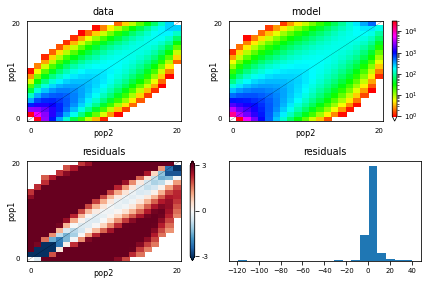

In [297]:
pylab.figure(1)
moments.Plotting.plot_2d_comp_multinom(
    model, data, vmin=1, resid_range=3, pop_ids=("pop1", "pop2")
)

In [270]:
#NN_1 = np.array(NN)
NN_mean1 = np.mean(NN_1)
NN_mean1

1172.36

In [370]:
import moments
import numpy as np


def model_func(params, ns):
    """
    Simple two populations model. Ancestral population of constant size splits
    into two subpopulations of constant size with asymetrical migrations.
    :param nu1: Size of subpopulation 1 after split.
    :param nu2: Size of subpopulation 2 after split.
    :param m12: Migration rate from subpopulation 2 to subpopulation 1.
    :param m21: Migration rate from subpopulation 1 to subpopulation 2.
    :param T: Time of split.
    """

    nu1, nu2, m12, m21, T = params
    sts = moments.LinearSystem_1D.steady_state_1D(sum(ns))
    fs = moments.Spectrum(sts)

    fs = moments.Manips.split_1D_to_2D(fs, ns[0], ns[1])

    fs.integrate(Npop=[nu1, nu2], tf=T, m = np.array([[0,m12],[m21,0]]))
    return fs

Simulated data saved to fs_data.fs
Maximum log composite likelihood: -1310.930985309239
Optimal value of theta: 20000.0
Size of the ancestral population: 10000
Model plot is saved to model_plot.png


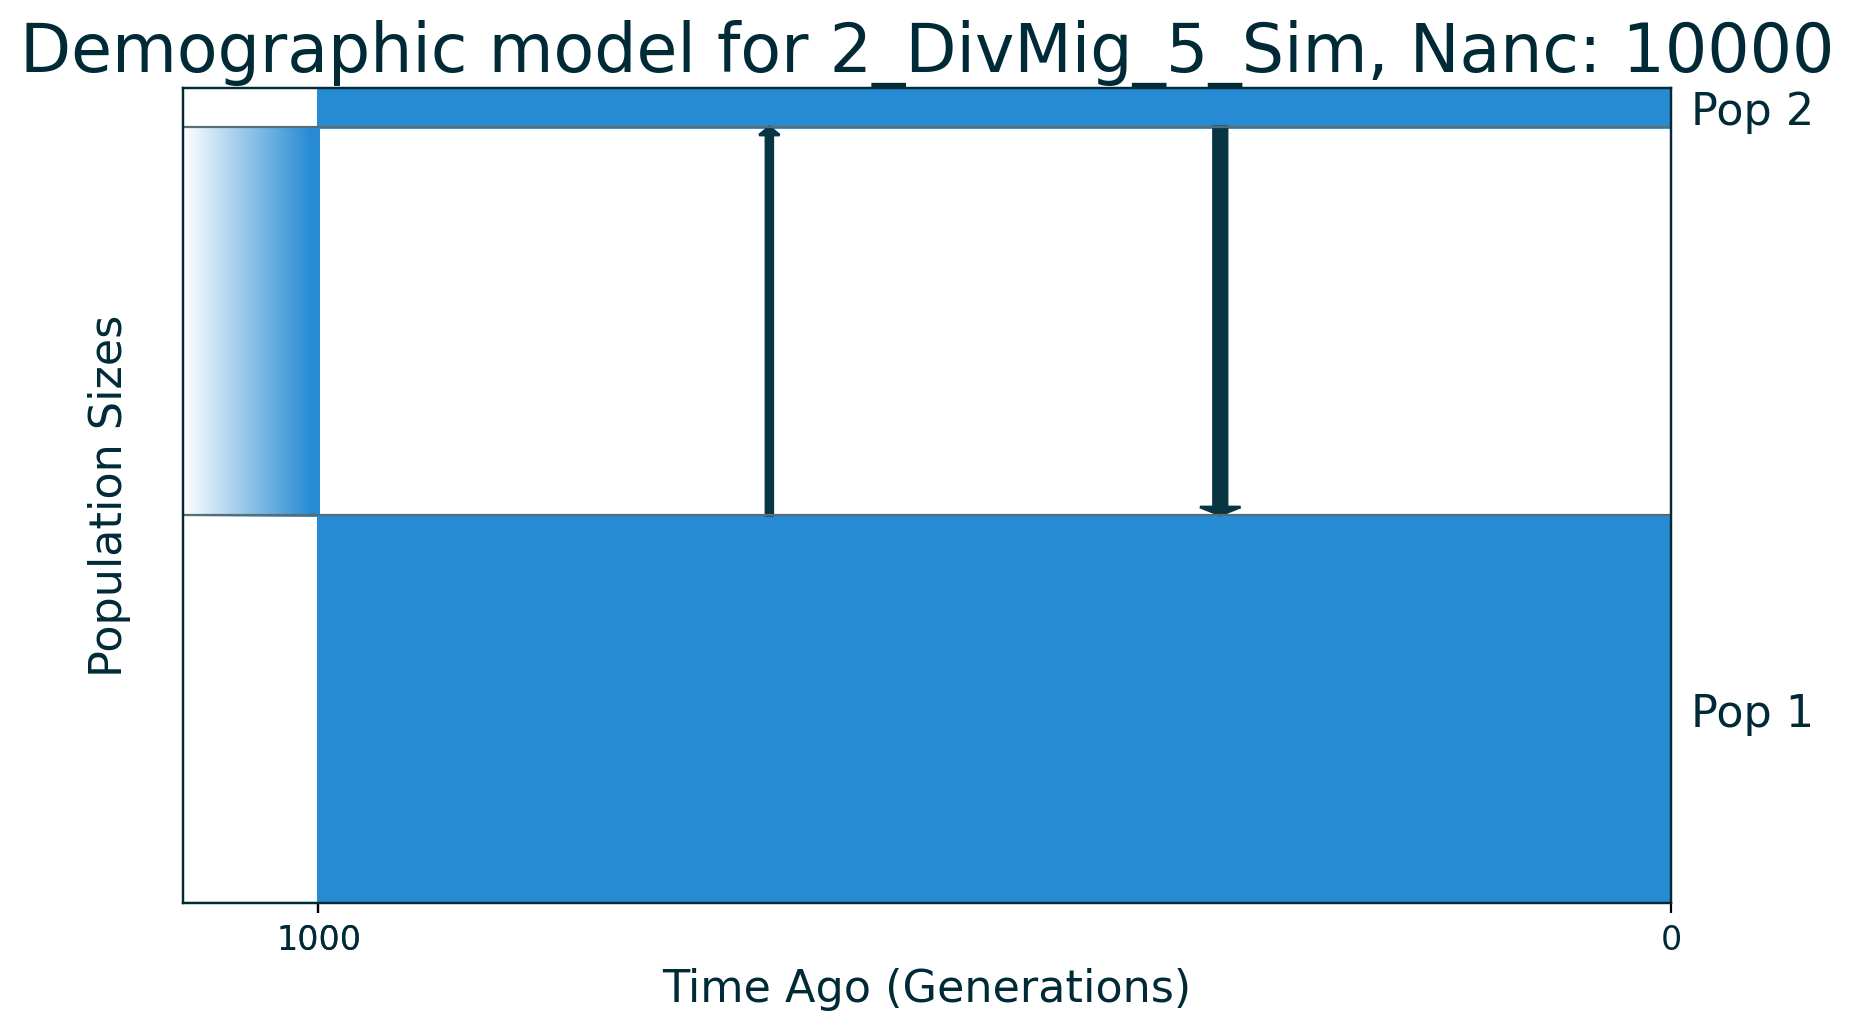

In [375]:
import moments

n_pop = 2
pop_labels = ["Pop 1", "Pop 2"]

par_labels = ['nu1', 'nu2', 'm12', 'm21', 'T']
popt = [1.0, 0.1, 5, 2.5, 0.05]

lower_bound = [1e-2, 1e-2, 0, 0, 1e-15]
upper_bound = [100, 100, 10, 10, 5]

mu = 2.5e-8  # mutation rate
L = 20000000  # effective length of sequence
Nanc = 10000
theta = 4 * mu * L * Nanc  # mutation flux

ns_per_pop = 20
ns = [ns_per_pop for _ in range(n_pop)]

# Get maximum log-likelihood
model = model_func(popt, ns)
data = model * theta
max_ll = moments.Inference.ll_multinom(model, data)

if __name__ == "__main__":
    data.to_file('fs_data.fs')
    print('Simulated data saved to fs_data.fs')

    print('Maximum log composite likelihood: {0}'.format(max_ll))

    theta = moments.Inference.optimal_sfs_scaling(model, data)
    print('Optimal value of theta: {0}'.format(theta))

    theta0 = 4 * mu * L
    Nanc = int(theta / theta0)
    print('Size of the ancestral population: {0}'.format(Nanc))

    # Draw model
    model = moments.ModelPlot.generate_model(model_func, popt,
                                             [4 for _ in range(n_pop)])
    moments.ModelPlot.plot_model(model,
        save_file='model_plot.png',
        fig_title=f'Demographic model for 2_DivMig_5_Sim, Nanc: {Nanc}',
        pop_labels=pop_labels,
        nref=Nanc,
        draw_scale=False,
        draw_ancestors=True,
        gen_time=1.0,
        gen_time_units='Generations',
        reverse_timeline=True)
    print('Model plot is saved to model_plot.png')

In [334]:
model

In [362]:
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta

data.to_file(f'/content/fs_data.txt')
with open('/content/fs_data.txt', 'r') as f:
    for i in range(1):
        f.readline()
    x = f.readline()
    with open('/content/data.txt', 'r+') as f:
        f.seek(0, 2) 
        f.write(x)

In [363]:
X = pd.read_table('data.txt',sep='\s+', engine='python').to_numpy()

In [369]:
pop_pred = RegressorChain2.predict(X)
list(pop_pred[1])

[1.0,
 0.09999999999999862,
 1.8840551077393188,
 2.499970089919097,
 0.050000001331758255]

Simulated data saved to fs_data.fs
Maximum log composite likelihood: -1310.931293623255
Optimal value of theta: 20000.0
Size of the ancestral population: 10000
Model plot is saved to model_plot.png


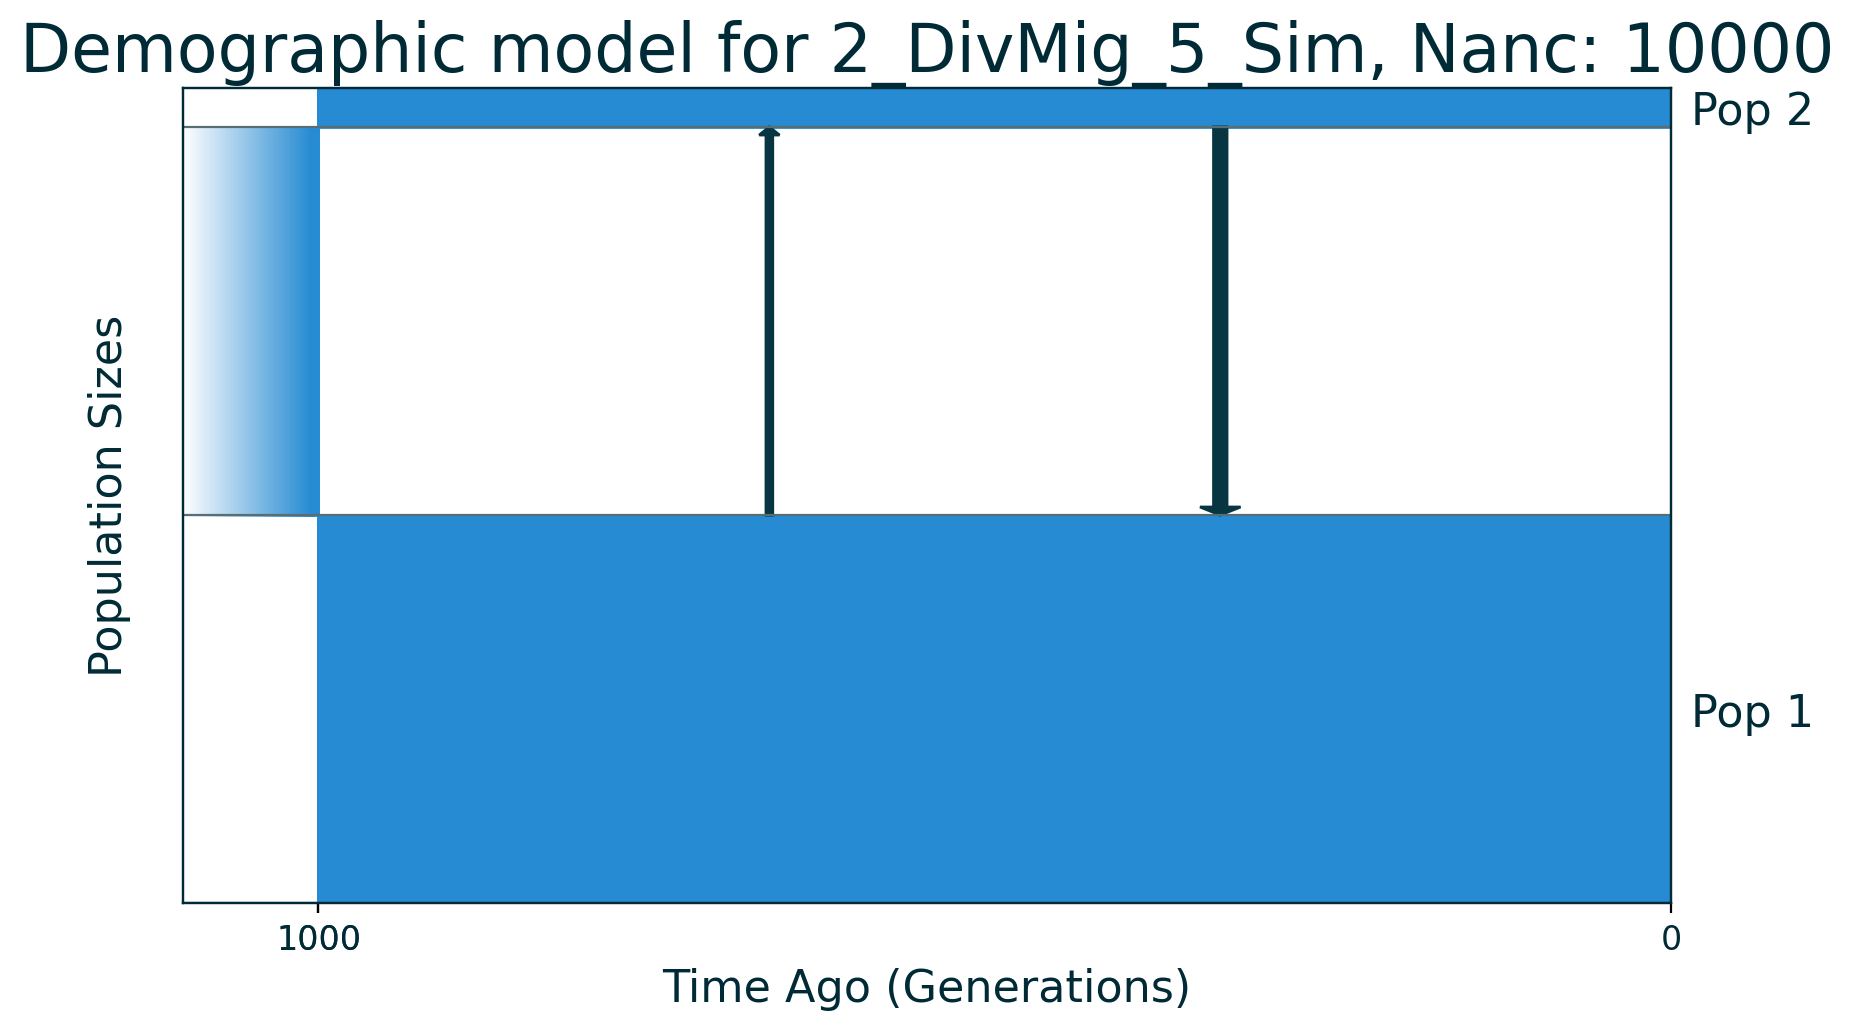

In [377]:
import moments

n_pop = 2
pop_labels = ["Pop 1", "Pop 2"]

par_labels = ['nu1', 'nu2', 'm12', 'm21', 'T']
popt = list(pop_pred[0])
lower_bound = [1e-2, 1e-2, 0, 0, 1e-15]
upper_bound = [100, 100, 10, 10, 5]

mu = 2.5e-8  # mutation rate
L = 20000000  # effective length of sequence
Nanc = 10000
theta = 4 * mu * L * Nanc  # mutation flux

ns_per_pop = 20
ns = [ns_per_pop for _ in range(n_pop)]

# Get maximum log-likelihood
model = model_func(popt, ns)
data = model * theta
max_ll = moments.Inference.ll_multinom(model, data)

if __name__ == "__main__":
    data.to_file('fs_data.fs')
    print('Simulated data saved to fs_data.fs')

    print('Maximum log composite likelihood: {0}'.format(max_ll))

    theta = moments.Inference.optimal_sfs_scaling(model, data)
    print('Optimal value of theta: {0}'.format(theta))

    theta0 = 4 * mu * L
    Nanc = int(theta / theta0)
    print('Size of the ancestral population: {0}'.format(Nanc))

    # Draw model
    model = moments.ModelPlot.generate_model(model_func, popt,
                                             [4 for _ in range(n_pop)])
    moments.ModelPlot.plot_model(model,
        save_file='model_plot.png',
        fig_title=f'Demographic model for 2_DivMig_5_Sim, Nanc: {Nanc}',
        pop_labels=pop_labels,
        nref=Nanc,
        draw_scale=False,
        draw_ancestors=True,
        gen_time=1.0,
        gen_time_units='Generations',
        reverse_timeline=True)
    print('Model plot is saved to model_plot.png')